<h1 div class='alert alert-success'><center> Feature Engineering </center></h1>


# <div class="alert alert-success">  OBJETIVO </div> 

O objetivo neste notebook é criação novas variáveis (feature) que possam ajudar na identificação de novos padrões, com a finalidade de bater a baseline estabelecida no [notebook]() de 0.94297 com XGBoost utilizando scaler MaxAbsScaler  e **n_estimators** com 1000.

# <div class="alert alert-success">  1. IMPORTAÇÕES </div> 

## 1.1. Instalações

In [2]:
# https://pub.towardsai.net/use-google-colab-like-a-pro-39a97184358d
COLAB = 'google.colab' in str(get_ipython()) 

if COLAB:        
    !pip install --q scikit-plot
    !pip install --q category_encoders
    !pip install --q shap
    !pip install --q inflection    
    !pip install --q pycaret

    from google.colab import drive
    drive.mount('/content/drive')

## 1.2. Bibliotecas 

In [85]:
import warnings
import random
import os
import gc
import torch
import math
import sklearn.exceptions
import shap

In [4]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import xgboost           as xgb
import scikitplot        as skplt
import category_encoders as ce 

In [5]:
from sklearn.model_selection import train_test_split,  KFold, StratifiedKFold, cross_validate
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, RobustScaler, Normalizer 
from sklearn.preprocessing   import MaxAbsScaler, QuantileTransformer, LabelEncoder, normalize
from sklearn.impute          import SimpleImputer
from sklearn                 import metrics
from datetime                import datetime
from sklearn.cluster         import KMeans
from sklearn.decomposition   import PCA

In [6]:
from yellowbrick.cluster        import KElbowVisualizer, SilhouetteVisualizer
from sklearn.utils.class_weight import compute_sample_weight
from scipy                      import stats
from scipy.cluster              import hierarchy as hc
from math                       import factorial
from scipy.stats                import mode
from sklearn.impute             import SimpleImputer, KNNImputer  
from sklearn.cluster            import MiniBatchKMeans
from sklearn.ensemble           import RandomForestClassifier
from sklearn.linear_model       import LogisticRegression

In [7]:
from sklearn.pipeline           import Pipeline
from sklearn.compose            import ColumnTransformer

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.lines as mlines
from pycaret.classification import *

## 1.3. Funções
Aqui centralizamos todas as funções desenvolvidas durante o projeto para melhor organização do código.

In [8]:
def jupyter_setting():
    
    %matplotlib inline
      
    #os.environ["WANDB_SILENT"] = "true" 
    #plt.style.use('bmh') 
    #plt.rcParams['figure.figsize'] = [20,15]
    #plt.rcParams['font.size']      = 13
     
    pd.options.display.max_columns = None
    #pd.set_option('display.expand_frame_repr', False)

    warnings.filterwarnings(action='ignore')
    warnings.simplefilter('ignore')
    warnings.filterwarnings('ignore')
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    warnings.filterwarnings('ignore', category=UserWarning)
    warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
    warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)

    pd.set_option('display.max_rows', 200)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.max_colwidth', None)

    icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
    #sns.palplot(sns.color_palette(icecream))
    
    colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
          "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
          "lightskyblue", "sandybrown", "yellowgreen", "indianred",
          "lightsteelblue", "mediumorchid", "deepskyblue"]
    
    # Colors
    dark_red   = "#b20710"
    black      = "#221f1f"
    green      = "#009473"
    myred      = '#CD5C5C'
    myblue     = '#6495ED'
    mygreen    = '#90EE90'    
    color_cols = [myred, myblue,mygreen]
    
    return icecream, colors, color_cols

icecream, colors, color_cols = jupyter_setting()

In [9]:
def reduce_memory_usage(df, verbose=True):
    
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    
    for col in df.columns:
        
        col_type = df[col].dtypes
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
        
    return df

In [10]:
def missing_zero_values_table(df):
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()

In [11]:
def scaler_MaxAbsScaler_StandardScaler(df):    
    sc_mm = MaxAbsScaler()
    sc_st = StandardScaler()     
    col = df.columns
    df  = sc_mm.fit_transform(df)
    df  = pd.DataFrame(sc_st.fit_transform(df), columns=col)    
    return df

In [12]:
def diff(t_a, t_b):
    from dateutil.relativedelta import relativedelta
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

In [13]:
def free_gpu_cache():
    
    # https://www.kaggle.com/getting-started/140636
    #print("Initial GPU Usage")
    #gpu_usage()                             

    #cuda.select_device(0)
    #cuda.close()
    #cuda.select_device(0)   
    
    gc.collect()
    torch.cuda.empty_cache()

In [14]:
def cromer_v(x, y):
    cm       = pd.crosstab(x, y).to_numpy()        
    n        = cm.sum()
    r, k     = cm.shape
    chi2     = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1) * (r-1) /(n-1))
    kcorr    = k - (k-1) **2/(n-1)
    rcorr    = r - (r-1) **2/(n-1)    
    v        = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))        
    return v  

In [15]:
def generate_category_table(data):

    cols    = data.select_dtypes(include='object').columns
    dataset = pd.DataFrame()

    for i in cols:
        corr = []
        for x in cols: 
            corr.append(cromer_v(data[i],data[x]))

        aux     = pd.DataFrame({i:corr})
        dataset = pd.concat([dataset, aux], axis=1) 

    return dataset.set_index(dataset.columns)

In [16]:
def graf_feature_corr(df, annot_=False, threshold=.8, print_var=False):
    
    df = df.corr(method ='pearson').round(5)

    # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
    mask = np.zeros_like(df)
    mask[np.triu_indices_from(mask)] = True

    # Making a plot
    ax = sns.heatmap(df, annot=annot_, mask=mask, cmap="RdBu", annot_kws={"weight": "bold", "fontsize":13})

    ax.set_title("Mapa de calor de correlação das variável", fontsize=17)

    plt.setp(ax.get_xticklabels(), 
             rotation      = 90, 
             ha            = "right",
             rotation_mode = "anchor", 
             weight        = "normal")

    plt.setp(ax.get_yticklabels(), 
             weight        = "normal",
             rotation_mode = "anchor", 
             rotation      = 0, 
             ha            = "right");
    
    if print_var: 
        print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold))
        df_corr = df[abs(df)>threshold][df!=1.0].unstack().dropna().reset_index()
        df_corr.columns =  ['var_1', 'var_2', 'corr']
        display(df_corr)

In [17]:
def identifies_outliers(df_):

    cols_num = df_.select_dtypes(np.number).columns

    for col in cols_num:   
        Q1  = df_[col].quantile(0.25)
        Q3  = df_[col].quantile(0.75)
        IQR = Q3-Q1
        lowqe_bound=Q1 - 1.5 * IQR
        upper_bound=Q3 + 1.5 * IQR

        df_['fe_outliers_'+ col] = 0
        df_['fe_outliers_'+ col][(df_[col]<=lowqe_bound)|(df_[col]>=upper_bound)] = 1    
            
        df_[col] = np.where(df_[col] > df_[col].quantile(0.95), df_[col].median(), df_[col])
    
    return df_

## 1.4. Criar estrutura de pasta 


In [18]:
paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'Data/tunning', 
         'model', 'model/preds', 'model/optuna','model/preds/test', 'model/mdl/',
         'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
         'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
         'model/preds/train/n3', 'model/preds/param']

for path in paths:
    try:
        os.mkdir(path)
    except:
        pass  

## 1.5. Dataset

### 1.5.2. Carregar Dados

In [19]:
path        = '/content/drive/MyDrive/Flai/08/' if COLAB else ''   
path_data   = 'Data/'  
target      = 'turnover_apos_1_ano'
path_automl = 'automl/'

In [20]:
df1_train     = pd.read_csv(path + path_data + 'treino.csv', sep=';', decimal=',')
df1_test      = pd.read_csv(path + path_data + 'teste.csv', sep=';', decimal=',')
df1_ibge_uf   = pd.read_csv(path + path_data + 'ibge_uf.csv', sep=';', decimal=',', encoding='latin-1')

df1_train.shape, df1_test.shape , df1_ibge_uf.shape

((15000, 11), (15000, 10), (27, 11))

### 1.5.3. Visualizar os dados 

In [21]:
df1_train.head()

,func_sexo,func_idade,func_racacor,func_escolaridade,func_uf,func_deficiencia,empresa_porte,empresa_setor,contrato_horastrabalho,contrato_salario,turnover_apos_1_ano
0,MASCULINO,24,AMARELA-BRANCA,MEDIO COMPLETO,RN,NAO,DE 10 A 19,Serviços,44,1750.65,SIM
1,MASCULINO,24,SEM INFO,MEDIO COMPLETO,BA,NAO,ATE 4,Comércio,44,1002.30,NAO
2,FEMININO,25,PRETA-PARDA,MEDIO COMPLETO,SE,NAO,DE 20 A 49,Comércio,44,1370.14,NAO
3,MASCULINO,54,PRETA-PARDA,MEDIO COMPLETO,PE,NAO,DE 20 A 49,Comércio,44,1854.68,SIM
4,MASCULINO,40,PRETA-PARDA,MEDIO COMPLETO,BA,NAO,DE 20 A 49,Comércio,0,1126.23,NAO


In [22]:
df1_test.head()

,func_sexo,func_idade,func_racacor,func_escolaridade,func_uf,func_deficiencia,empresa_porte,empresa_setor,contrato_horastrabalho,contrato_salario
0,FEMININO,30,PRETA-PARDA,MEDIO COMPLETO,MA,NAO,ATE 4,Comércio,44,1583.19
1,MASCULINO,21,SEM INFO,MEDIO COMPLETO,BA,NAO,DE 5 A 9,Indústria,44,979.95
2,FEMININO,26,SEM INFO,MEDIO COMPLETO,RN,NAO,ATE 4,Comércio,44,1015.85
3,MASCULINO,49,PRETA-PARDA,MEDIO COMPLETO,BA,NAO,DE 5 A 9,Comércio,44,1089.45
4,FEMININO,31,SEM INFO,MEDIO COMPLETO,BA,NAO,ATE 4,Serviços,44,1281.62


In [23]:
df1_test.head()

,func_sexo,func_idade,func_racacor,func_escolaridade,func_uf,func_deficiencia,empresa_porte,empresa_setor,contrato_horastrabalho,contrato_salario
0,FEMININO,30,PRETA-PARDA,MEDIO COMPLETO,MA,NAO,ATE 4,Comércio,44,1583.19
1,MASCULINO,21,SEM INFO,MEDIO COMPLETO,BA,NAO,DE 5 A 9,Indústria,44,979.95
2,FEMININO,26,SEM INFO,MEDIO COMPLETO,RN,NAO,ATE 4,Comércio,44,1015.85
3,MASCULINO,49,PRETA-PARDA,MEDIO COMPLETO,BA,NAO,DE 5 A 9,Comércio,44,1089.45
4,FEMININO,31,SEM INFO,MEDIO COMPLETO,BA,NAO,ATE 4,Serviços,44,1281.62


In [24]:
df1_ibge_uf.head()

,estado,func_uf,area_territorial_km2,populacao_estimada,densidade_demografica_hab_km2,matriculas_ensino_fundamental,IDH,receitas_realizadas _x1000,despesas_empenhadas_×1000,rendimento_mensal_domiciliar_per_capita,total_veículos
0,Acre,AC,164173.431,906876,4.47,156679,0.663,6.632883e+06,6.084417e+06,888,306258
1,Alagoas,AL,27830.661,3365351,112.33,464704,0.631,1.195044e+07,1.046063e+07,777,930933
2,Amapá,AP,142470.762,877613,4.69,134820,0.708,5.396417e+06,4.224464e+06,855,215330
3,Amazonas,AM,1559167.878,4269995,2.23,700104,0.674,1.732846e+07,1.532490e+07,800,969722
4,Bahia,BA,564760.429,14985284,24.82,1947177,0.660,5.019100e+07,4.557016e+07,843,4506825


In [25]:
df1_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   func_sexo               15000 non-null  object 
 1   func_idade              15000 non-null  int64  
 2   func_racacor            15000 non-null  object 
 3   func_escolaridade       15000 non-null  object 
 4   func_uf                 15000 non-null  object 
 5   func_deficiencia        15000 non-null  object 
 6   empresa_porte           15000 non-null  object 
 7   empresa_setor           15000 non-null  object 
 8   contrato_horastrabalho  15000 non-null  int64  
 9   contrato_salario        15000 non-null  float64
 10  turnover_apos_1_ano     15000 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 1.3+ MB


# <div class="alert alert-success"> 2. PROCESSAMENTO </div> 

In [26]:
df2_train = df1_train.copy()
df2_test  = df1_test.copy()

df2_train.shape, df2_test.shape

((15000, 11), (15000, 10))

In [27]:
df2_train.head()

,func_sexo,func_idade,func_racacor,func_escolaridade,func_uf,func_deficiencia,empresa_porte,empresa_setor,contrato_horastrabalho,contrato_salario,turnover_apos_1_ano
0,MASCULINO,24,AMARELA-BRANCA,MEDIO COMPLETO,RN,NAO,DE 10 A 19,Serviços,44,1750.65,SIM
1,MASCULINO,24,SEM INFO,MEDIO COMPLETO,BA,NAO,ATE 4,Comércio,44,1002.30,NAO
2,FEMININO,25,PRETA-PARDA,MEDIO COMPLETO,SE,NAO,DE 20 A 49,Comércio,44,1370.14,NAO
3,MASCULINO,54,PRETA-PARDA,MEDIO COMPLETO,PE,NAO,DE 20 A 49,Comércio,44,1854.68,SIM
4,MASCULINO,40,PRETA-PARDA,MEDIO COMPLETO,BA,NAO,DE 20 A 49,Comércio,0,1126.23,NAO


## 2.1. Excluir variáveis

In [28]:
features = df2_train.columns[df2_train.columns!=target]
features

Index(['func_sexo', 'func_idade', 'func_racacor', 'func_escolaridade',
       'func_uf', 'func_deficiencia', 'empresa_porte', 'empresa_setor',
       'contrato_horastrabalho', 'contrato_salario'],
      dtype='object')

## 2.2. Duplicados 

In [29]:
df2_train.duplicated().sum()

0

In [30]:
df2_test.duplicated().sum()

0

## 2.3. Redução dos datasets

In [31]:
df2_train = reduce_memory_usage(df2_train)
df2_test  = reduce_memory_usage(df2_test)

df2_train[target] = df2_train[target].map({'NAO':0, 'SIM':1})
df2_train.info()

Mem. usage decreased to 1.00 Mb (20.5% reduction)
Mem. usage decreased to 0.86 Mb (25.0% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   func_sexo               15000 non-null  object 
 1   func_idade              15000 non-null  int8   
 2   func_racacor            15000 non-null  object 
 3   func_escolaridade       15000 non-null  object 
 4   func_uf                 15000 non-null  object 
 5   func_deficiencia        15000 non-null  object 
 6   empresa_porte           15000 non-null  object 
 7   empresa_setor           15000 non-null  object 
 8   contrato_horastrabalho  15000 non-null  int8   
 9   contrato_salario        15000 non-null  float32
 10  turnover_apos_1_ano     15000 non-null  int64  
dtypes: float32(1), int64(1), int8(2), object(7)
memory usage: 1.0+ MB


## 2.4. Mesclar dados 
Vamos acrescentar os dados demográficos de cada estado obtidos no IBGE.

In [32]:
cols_ibge =  ['func_uf', 'IDH', 'densidade_demografica_hab_km2']
df2_train = pd.merge(df2_train, df1_ibge_uf[cols_ibge], on=['func_uf'])
df2_test  = pd.merge(df2_test, df1_ibge_uf[cols_ibge], on=['func_uf'])

df2_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   func_sexo                      15000 non-null  object 
 1   func_idade                     15000 non-null  int8   
 2   func_racacor                   15000 non-null  object 
 3   func_escolaridade              15000 non-null  object 
 4   func_uf                        15000 non-null  object 
 5   func_deficiencia               15000 non-null  object 
 6   empresa_porte                  15000 non-null  object 
 7   empresa_setor                  15000 non-null  object 
 8   contrato_horastrabalho         15000 non-null  int8   
 9   contrato_salario               15000 non-null  float32
 10  turnover_apos_1_ano            15000 non-null  int64  
 11  IDH                            15000 non-null  float64
 12  densidade_demografica_hab_km2  15000 non-null 

## 2.5. Split Train / Test

In [33]:
X      = df2_train.drop([target], axis=1)
y      = df2_train[target]
X_test = df2_test       

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.2,
                                                      shuffle      = True, 
                                                      stratify     = y, 
                                                      random_state = 12359)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape , X_test.shape

((12000, 12), (12000,), (3000, 12), (3000,), (15000, 12))

# <div class="alert alert-success"> 3. FEATURE ENGINEERING </div> 
Nesta parte do processo vamos criar diversas variávies com o intuito de ajudar o modelo a identificar novos padrões e consequentemente melhor o desempenho, como padrão vamos criar todas as variáveis com inicial **fe_**, a cada criação de novas variáveis vamos treinar o modelo __XGBoost__ e identificar se as novas variáveis ajudam a encontrar novos padrões.

In [34]:
feature_float = X_test.select_dtypes(np.number).columns.to_list()
feature_cat   = X_test.select_dtypes(object).columns.to_list()

print(feature_cat) 
print(feature_float)

['func_sexo', 'func_racacor', 'func_escolaridade', 'func_uf', 'func_deficiencia', 'empresa_porte', 'empresa_setor']
['func_idade', 'contrato_horastrabalho', 'contrato_salario', 'IDH', 'densidade_demografica_hab_km2']


## 3.1. Feature Dammies

In [35]:
def feature_statistic(df_, feature_float_):
           
    df_['fe_median']       = df_[feature_float_].median(axis=1) 
    #df_['fe_skew']         = df_[feature_float_].skew(axis=1)   
    df_['fe_quantile_25']  = df_[feature_float_].quantile(q=.25, axis=1)    
    df_['fe_quantile_75']  = df_[feature_float_].quantile(q=.75, axis=1)    
    df_['fe_dispersion_1'] = df_['fe_median'] / (df_['fe_quantile_75'] - df_['fe_quantile_25'])   

    df_['fe_tails']        = (df_[feature_float_].max(axis=1) - 
                              df_[feature_float_].min(axis=1)) / \
                              (df_[feature_float_].quantile(q=.75, axis=1) - \
                               df_[feature_float_].quantile(q=.25, axis=1))
    
    df_ = reduce_memory_usage(df_, verbose=False)
    
    return df_

In [36]:
def df_trans_dammy(df_): 
    df_ = pd.get_dummies(df_, drop_first=True)    
    return df_

In [37]:
def df_proc_math(X_train_, X_valid_, X_test_):

    # Contrato de trbalho
    media_contrato_horastrabalho = int(X_train_['contrato_horastrabalho'].mean())
    bottom_horas_semana          = int(X_train_['contrato_horastrabalho'].quantile(0.025))

    for df in ([X_train_, X_valid_, X_test_]): 
        df['contrato_horastrabalho_zero'] = df['contrato_horastrabalho'].apply(lambda x:1 if x==0 else 0)         
        df['contrato_horastrabalho'][df['contrato_horastrabalho']<10] = media_contrato_horastrabalho        
        df['contrato_horastrabalho'][df['contrato_horastrabalho']<bottom_horas_semana]= media_contrato_horastrabalho
        df['func_racacor'][df['func_racacor']=='INDIGENA'] = 'PRETA-PARDA'
        df['func_idade'] = df['func_idade'] ** (1/3)
        df['fe_media_sal_idade'] = (df['contrato_salario'] / df['func_idade'])
                        
        #df.drop('contrato_horastrabalho', axis=1, inplace=True) 
        
    return X_train_, X_valid_, X_test_

In [38]:
X_train_fe = feature_statistic(X_train.copy(), feature_float) 
X_valid_fe = feature_statistic(X_valid.copy(), feature_float) 
X_test_fe  = feature_statistic(X_test.copy(), feature_float) 
X_train_fe.shape, X_valid_fe.shape, X_test_fe.shape

((12000, 17), (3000, 17), (15000, 17))

In [39]:
X_train_fe.filter(regex='fe_').head()

,fe_median,fe_quantile_25,fe_quantile_75,fe_dispersion_1,fe_tails
10598,44.0,26.000000,56.7500,1.430664,35.750000
7096,40.0,23.000000,89.6250,0.600586,32.593750
5095,24.0,21.000000,24.8125,6.281250,242.500000
5922,44.0,31.000000,89.6250,0.750488,30.546875
13284,37.0,12.398438,44.0000,1.170898,122.562500


In [40]:
X_train_pm, X_valid_pm, X_test_pm = df_proc_math(X_train_fe.copy(), X_valid_fe.copy(), X_test_fe.copy())

X_train_pm.shape, X_valid_pm.shape, X_test_pm.shape 

((12000, 19), (3000, 19), (15000, 19))

In [41]:
X_train_pm.select_dtypes(np.number) .head()

,func_idade,contrato_horastrabalho,contrato_salario,IDH,densidade_demografica_hab_km2,fe_median,fe_quantile_25,fe_quantile_75,fe_dispersion_1,fe_tails,contrato_horastrabalho_zero,fe_media_sal_idade
10598,2.962496,44,1100.329956,0.682129,56.750000,44.0,26.000000,56.7500,1.430664,35.750000,0,371.419887
7096,2.843867,40,2172.790039,0.672852,89.625000,40.0,23.000000,89.6250,0.600586,32.593750,0,764.026607
5095,2.758924,24,927.169983,0.660156,24.812500,24.0,21.000000,24.8125,6.281250,242.500000,0,336.062147
5922,3.141381,44,1791.349976,0.672852,89.625000,44.0,31.000000,89.6250,0.750488,30.546875,0,570.242888
13284,3.332222,44,3874.179932,0.645996,12.398438,37.0,12.398438,44.0000,1.170898,122.562500,0,1162.641656


In [42]:
X_train_dammies =  df_trans_dammy(X_train_pm)
X_valid_dammies =  df_trans_dammy(X_valid_pm)
X_test_dammies  =  df_trans_dammy(X_test_pm)

del X_train_fe, X_valid_fe, X_test_fe
del X_train_pm, X_valid_pm, X_test_pm

X_train_dammies.shape, X_valid_dammies.shape, X_test_dammies.shape

((12000, 41), (3000, 41), (15000, 41))

In [43]:
X_train_dammies.head()

,func_idade,contrato_horastrabalho,contrato_salario,IDH,densidade_demografica_hab_km2,fe_median,fe_quantile_25,fe_quantile_75,fe_dispersion_1,fe_tails,contrato_horastrabalho_zero,fe_media_sal_idade,func_sexo_MASCULINO,func_racacor_PRETA-PARDA,func_racacor_SEM INFO,func_escolaridade_FUND_COMPLETO-MEDIO_INCOMPLETO,func_escolaridade_MEDIO COMPLETO,func_escolaridade_SUPERIOR_COMPLETO,func_escolaridade_SUPERIOR_INCOMPLETO,func_uf_BA,func_uf_CE,func_uf_MA,func_uf_PB,func_uf_PE,func_uf_PI,func_uf_RN,func_uf_SE,func_deficiencia_SIM,empresa_porte_ATE 4,empresa_porte_DE 10 A 19,empresa_porte_DE 100 A 249,empresa_porte_DE 20 A 49,empresa_porte_DE 250 A 499,empresa_porte_DE 5 A 9,empresa_porte_DE 50 A 99,empresa_porte_DE 500 A 999,empresa_setor_Agricultura,empresa_setor_Comércio,empresa_setor_Construçao civil,empresa_setor_Indústria,empresa_setor_Serviços
10598,2.962496,44,1100.329956,0.682129,56.750000,44.0,26.000000,56.7500,1.430664,35.750000,0,371.419887,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
7096,2.843867,40,2172.790039,0.672852,89.625000,40.0,23.000000,89.6250,0.600586,32.593750,0,764.026607,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
5095,2.758924,24,927.169983,0.660156,24.812500,24.0,21.000000,24.8125,6.281250,242.500000,0,336.062147,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
5922,3.141381,44,1791.349976,0.672852,89.625000,44.0,31.000000,89.6250,0.750488,30.546875,0,570.242888,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
13284,3.332222,44,3874.179932,0.645996,12.398438,37.0,12.398438,44.0000,1.170898,122.562500,0,1162.641656,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


Variáveis autocorrelacionadas threshold=0.80


,var_1,var_2,corr
0,contrato_salario,fe_media_sal_idade,0.99186
1,densidade_demografica_hab_km2,fe_quantile_75,0.95633
2,fe_quantile_75,densidade_demografica_hab_km2,0.95633
3,fe_media_sal_idade,contrato_salario,0.99186


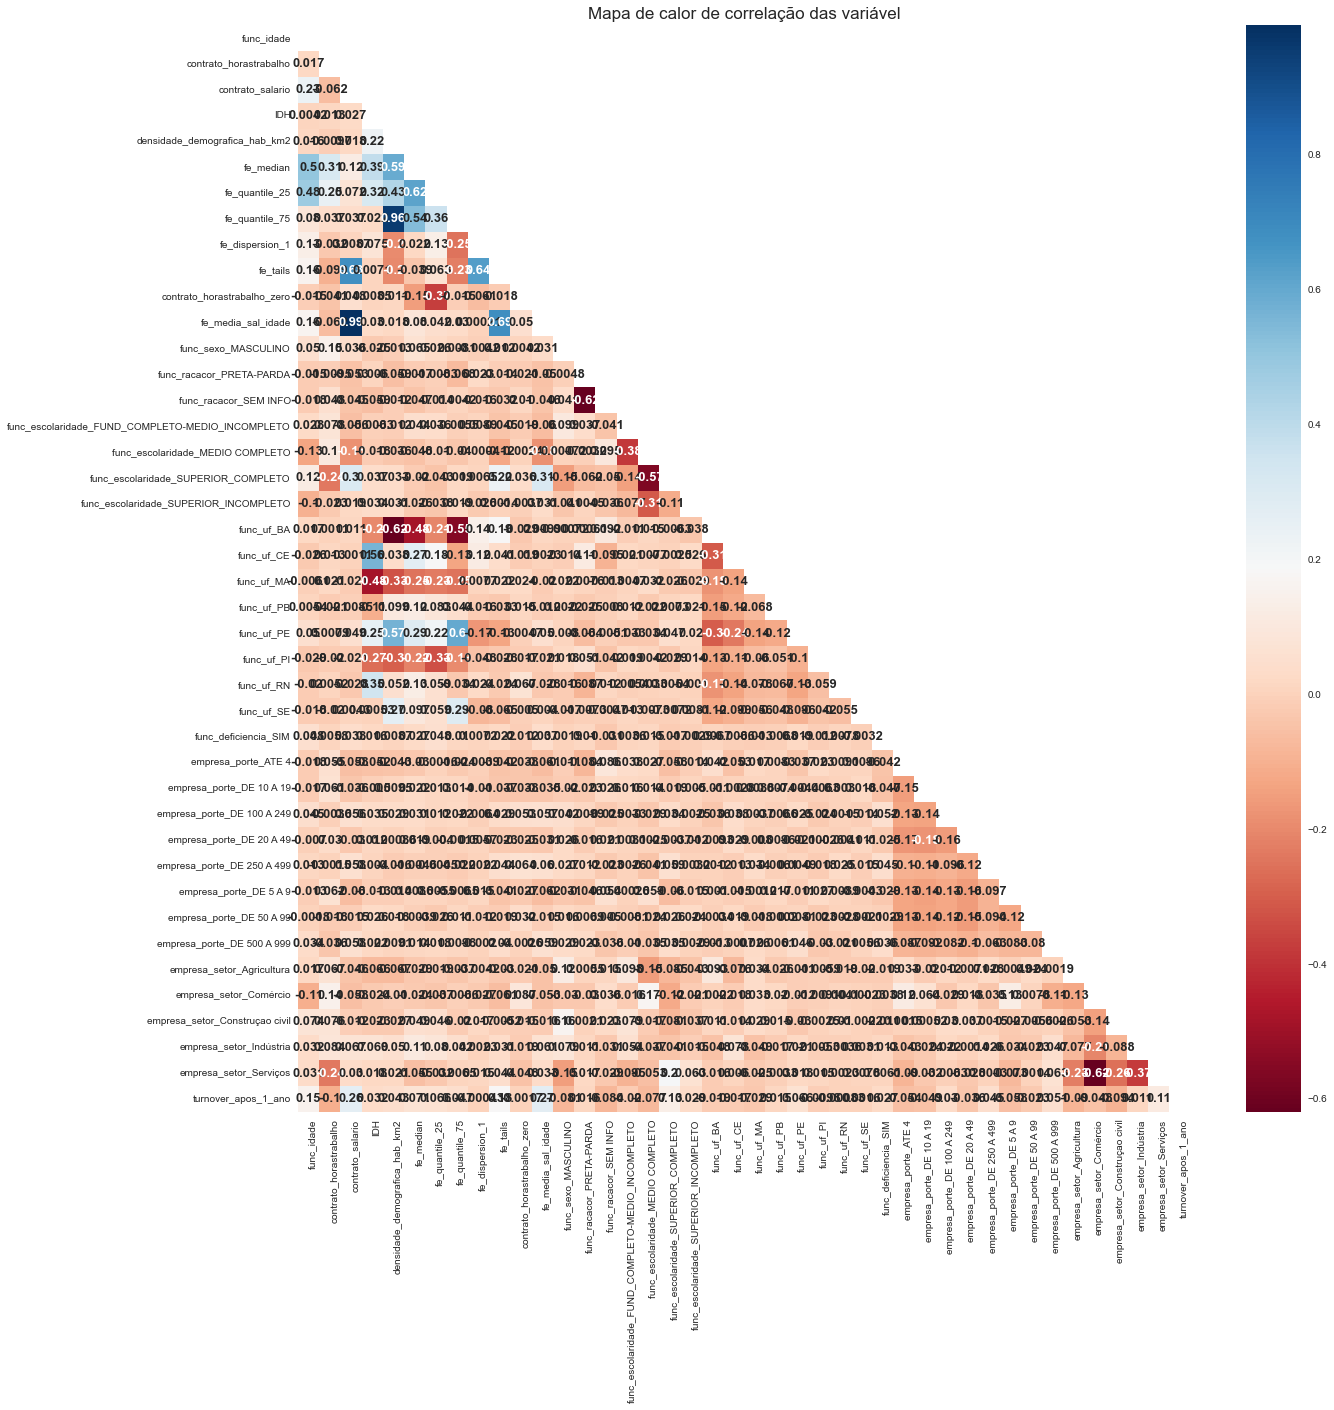

In [44]:
plt.figure(figsize=(20,20))

df_corr = X_train_dammies.copy()
df_corr[target] = y_train 
graf_feature_corr(df=df_corr, annot_=True, threshold=.8, print_var=True)
del df_corr



## 3.2. Feature Mista

In [45]:
def feature_target_encoder(X_train_, y_train_, X_valid_, X_test_):

    # Targe Encoder
    cols_te        = ['func_uf', 'empresa_porte', 'empresa_setor', 'func_racacor']
    target_encoder = ce.TargetEncoder(cols=cols_te, smoothing=0)

    train_enc = target_encoder.fit_transform(X_train_[cols_te], y=y_train_)
    valid_enc = target_encoder.transform(X_valid_[cols_te])
    test_enc  = target_encoder.transform(X_test_[cols_te])

    X_train_[cols_te]  = train_enc
    X_valid_[cols_te]  = valid_enc
    X_test_[cols_te]   = test_enc

    return X_train_, X_valid_, X_test_

In [46]:
def feature_mista(X_train_, y_, X_valid_, X_test_):

    cols_ibge = ['func_uf', 
                 'IDH', 
                 'densidade_demografica_hab_km2', 
                 'total_veículos', 
                 'populacao_estimada']

    map_escolaridae = {'ANALFABETO-FUND_INCOMPLETO'    : 1,
                       'FUND_COMPLETO-MEDIO_INCOMPLETO': 2,
                       'MEDIO COMPLETO'                : 3,
                       'SUPERIOR_INCOMPLETO'           : 4, 
                       'SUPERIOR_COMPLETO'             : 5}

    for df in [X_train_, X_valid_, X_test_]:
        #df['func_escolaridade']  = df['func_escolaridade'].map(map_escolaridae).astype(int)
        df['func_racacor'][df['func_racacor']=='INDIGENA'] = 'PRETA-PARDA'
        df['func_idade'] = df['func_idade'] ** (1/3)
        df['fe_media_sal_idade'] = (df['contrato_salario'] / df['func_idade'])
 
    X_train_, X_valid_, X_test_ = feature_target_encoder(X_train_, y_, X_valid_, X_test_)

    X_train_ = pd.get_dummies(X_train_, drop_first=True)
    X_valid_ = pd.get_dummies(X_valid_, drop_first=True)
    X_test_  = pd.get_dummies(X_test_, drop_first=True)


    return X_train_, X_valid_, X_test_

In [47]:
X_train_fe = feature_statistic(X_train.copy(), feature_float) 
X_valid_fe = feature_statistic(X_valid.copy(), feature_float) 
X_test_fe  = feature_statistic(X_test.copy(), feature_float) 

X_train_fe.filter(regex='fe_').head()

,fe_median,fe_quantile_25,fe_quantile_75,fe_dispersion_1,fe_tails
10598,44.0,26.000000,56.7500,1.430664,35.750000
7096,40.0,23.000000,89.6250,0.600586,32.593750
5095,24.0,21.000000,24.8125,6.281250,242.500000
5922,44.0,31.000000,89.6250,0.750488,30.546875
13284,37.0,12.398438,44.0000,1.170898,122.562500


In [48]:
X_train_mista, X_valid_mista, X_test_mista = feature_mista(X_train_fe,
                                                           y_train, 
                                                           X_valid_fe, 
                                                           X_test_fe)

X_train_mista.shape, X_valid_mista.shape, X_test_mista.shape

((12000, 21), (3000, 21), (15000, 21))

In [49]:
X_valid_mista.head()

,func_idade,func_racacor,func_uf,empresa_porte,empresa_setor,contrato_horastrabalho,contrato_salario,IDH,densidade_demografica_hab_km2,fe_median,fe_quantile_25,fe_quantile_75,fe_dispersion_1,fe_tails,fe_media_sal_idade,func_sexo_MASCULINO,func_escolaridade_FUND_COMPLETO-MEDIO_INCOMPLETO,func_escolaridade_MEDIO COMPLETO,func_escolaridade_SUPERIOR_COMPLETO,func_escolaridade_SUPERIOR_INCOMPLETO,func_deficiencia_SIM
7051,2.884499,0.365660,0.425607,0.522480,0.410794,36,1554.0,0.672852,89.6250,36.0000,24.0,89.6250,0.548828,23.656250,538.741710,0,0,0,0,1,0
4795,2.714418,0.270588,0.345822,0.282258,0.410794,22,624.0,0.660156,24.8125,22.0000,20.0,24.8125,4.562500,129.375000,229.883566,0,0,1,0,0,0
1401,2.884499,0.270588,0.345822,0.300977,0.320608,44,2668.0,0.660156,24.8125,24.8125,24.0,44.0000,1.241211,133.375000,924.943940,0,0,1,0,0,0
6730,2.962496,0.365660,0.425607,0.300977,0.320608,44,1171.0,0.672852,89.6250,44.0000,26.0,89.6250,0.691406,18.390625,395.274786,0,0,1,0,0,0
11121,3.391211,0.365660,0.343315,0.439173,0.410794,36,1068.0,0.682129,56.7500,39.0000,36.0,56.7500,1.878906,51.437500,314.931704,1,0,1,0,0,0


### 3.2.1. Correlação 

Variáveis autocorrelacionadas threshold=0.60


,var_1,var_2,corr
0,contrato_salario,fe_tails,0.68067
1,contrato_salario,fe_media_sal_idade,0.99186
2,densidade_demografica_hab_km2,fe_quantile_75,0.95633
3,fe_median,fe_quantile_25,0.61582
4,fe_quantile_25,fe_median,0.61582
5,fe_quantile_75,densidade_demografica_hab_km2,0.95633
6,fe_dispersion_1,fe_tails,0.63778
7,fe_tails,contrato_salario,0.68067
8,fe_tails,fe_dispersion_1,0.63778
9,fe_tails,fe_media_sal_idade,0.68525


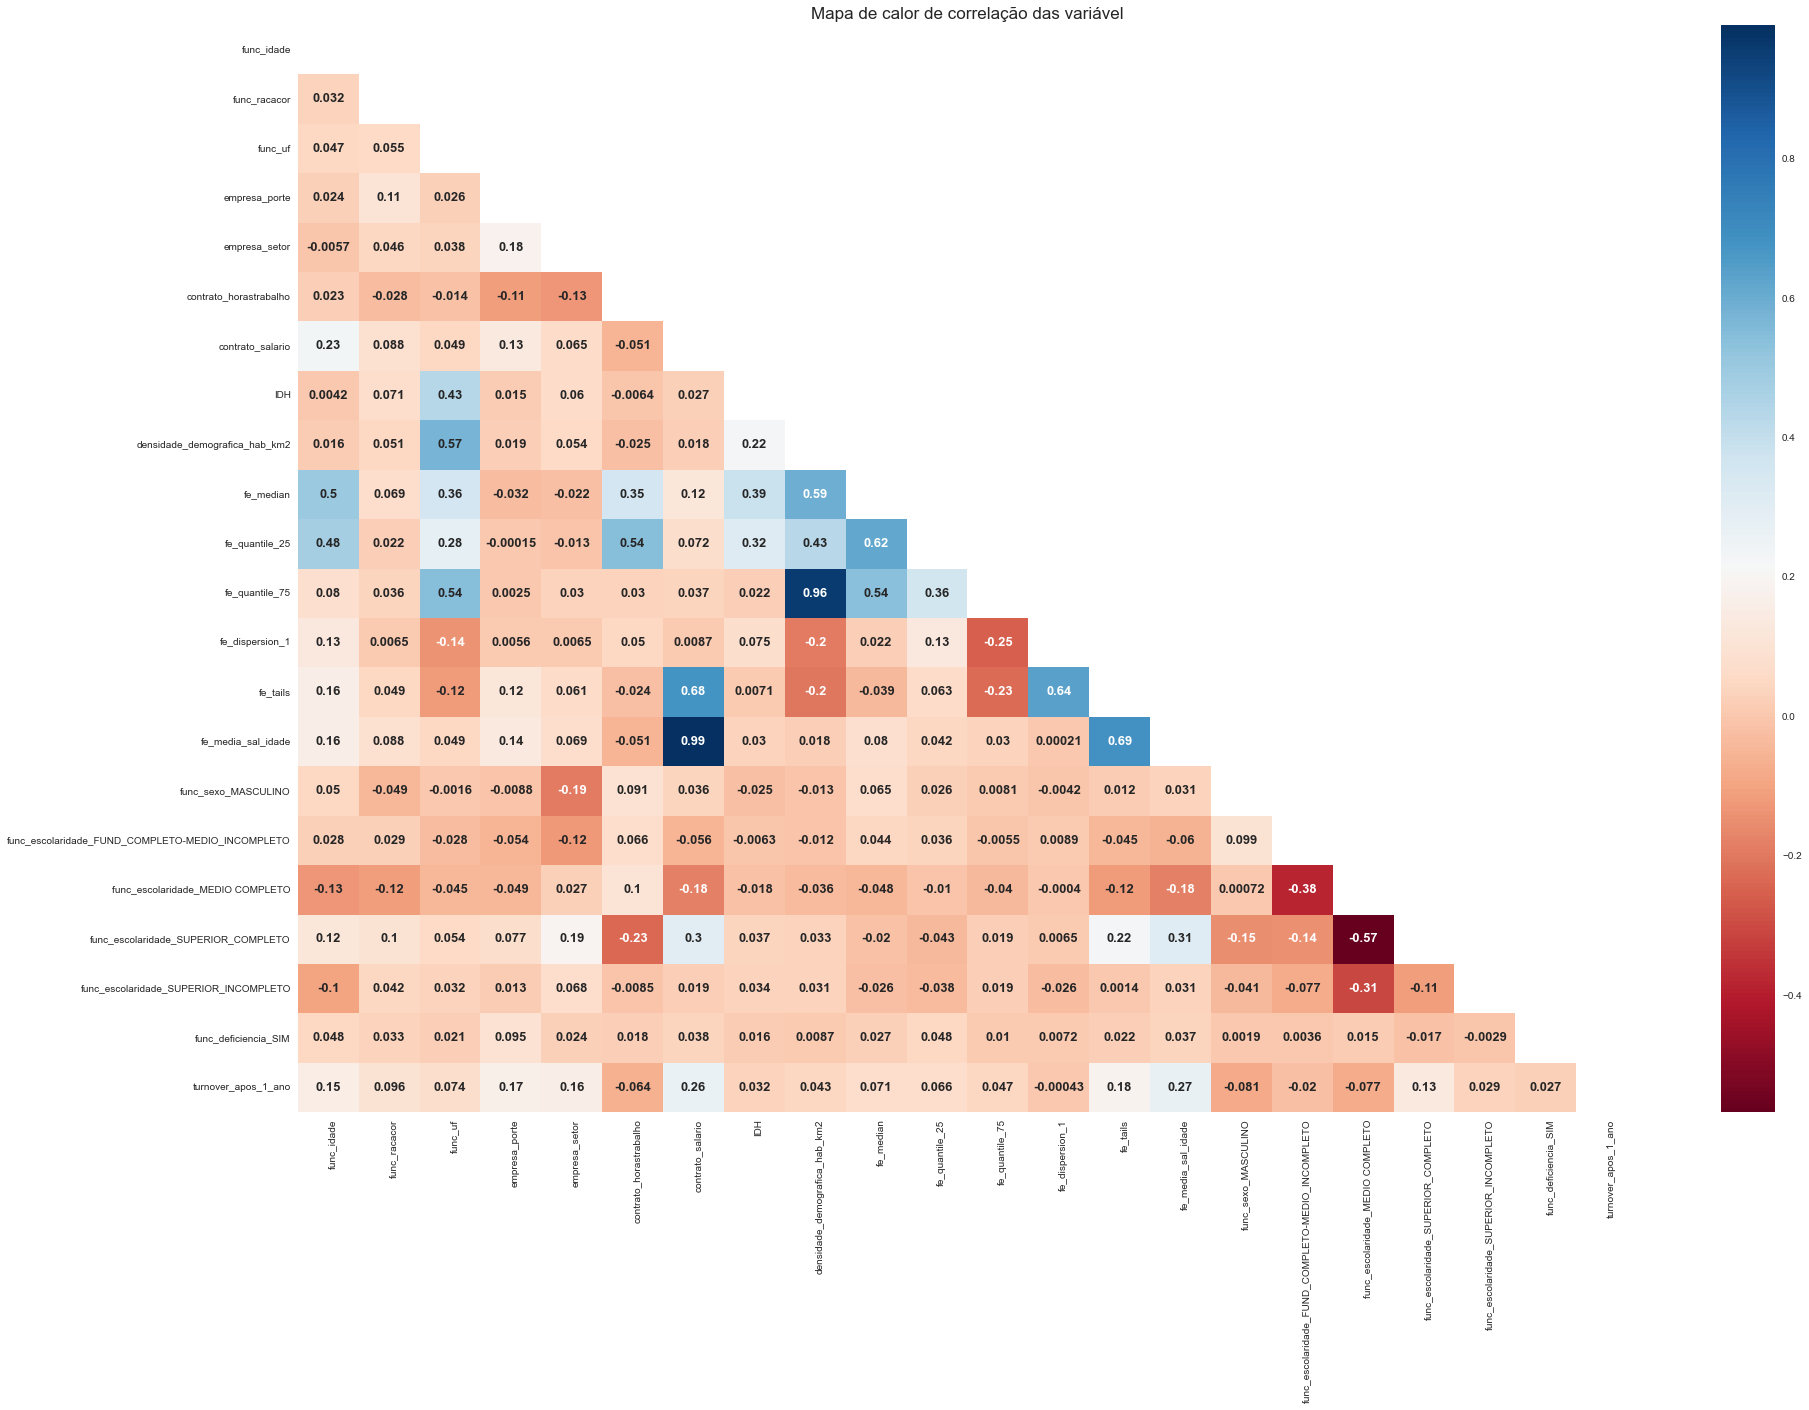

In [50]:
plt.figure(figsize=(30,20))

df_corr = X_train_mista.copy()
df_corr[target] = y_train 
graf_feature_corr(df=df_corr, annot_=True, threshold=.6, print_var=True)
del df_corr

## 3.3. Clustering

In [51]:
def create_clustering(X_train_, X_valid_, X_test_, sc_=StandardScaler(), gera_cluster=False, trans_cluster_dammi=False): 

    X_train_sc = sc_.fit_transform(X_train_) 
    X_valid_sc = sc_.transform(X_valid_)
    X_test_sc  = sc_.transform(X_test_)

    titleKElbow = 'O K-Cluster Ideal com Método de Cotovelo'
    model       = KMeans(random_state=12359) # MiniBatchKMeans() #
    visualizer  = KElbowVisualizer(model,  
                                    metric       = 'silhouette', 
                                    k            = (2,10), 
                                    locate_elbow = True, 
                                    timings      = False, 
                                    title        = titleKElbow, 
                                    size         = (1080, 720))
    visualizer.fit(X_train_sc)

    k       = visualizer.elbow_value_
    k_score = visualizer.elbow_score_

    visualizer.poof();

    if gera_cluster:
        model_kmeans = KMeans(n_clusters=k, random_state=12359)
        model_kmeans.fit(X_train_sc);

        for df in [X_train_, X_valid_, X_test_]:         
            df['fe_cluster'] =  model_kmeans.predict(df)        
        
        if trans_cluster_dammi:                 
            X_train_ = pd.get_dummies(X_train_, columns=['fe_cluster'], drop_first=True)
            X_valid_ = pd.get_dummies(X_valid_, columns=['fe_cluster'], drop_first=True)
            X_test_ = pd.get_dummies(X_test_, columns=['fe_cluster'], drop_first=True)  
    
    return X_train_, X_valid_, X_test_

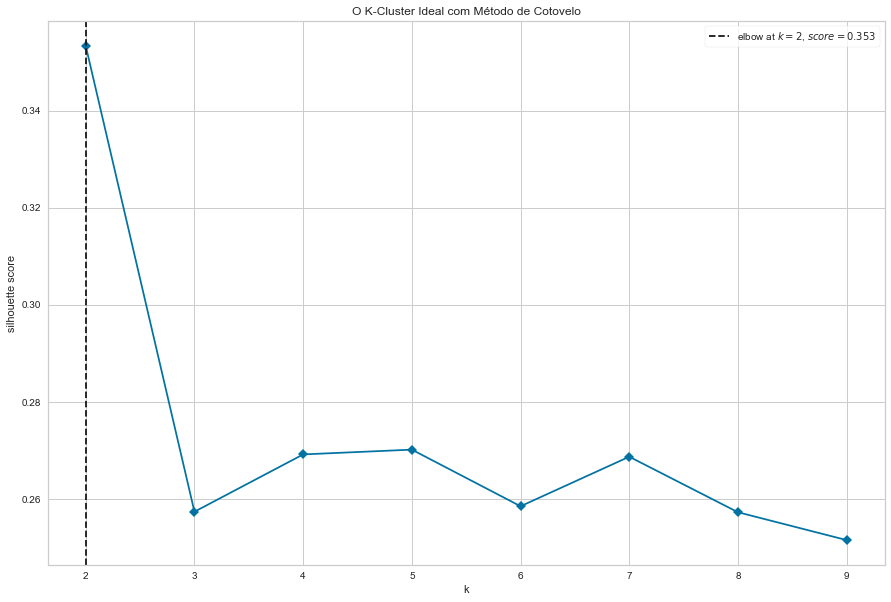

In [52]:
X_train_dammies, X_valid_dammies, X_test_dammies = create_clustering(X_train_dammies.copy(), 
                                                                     X_valid_dammies.copy(), 
                                                                     X_test_dammies.copy(), 
                                                                     sc_                = Normalizer(norm='max'), 
                                                                     gera_cluster       = True, 
                                                                     trans_cluster_dammi= True)

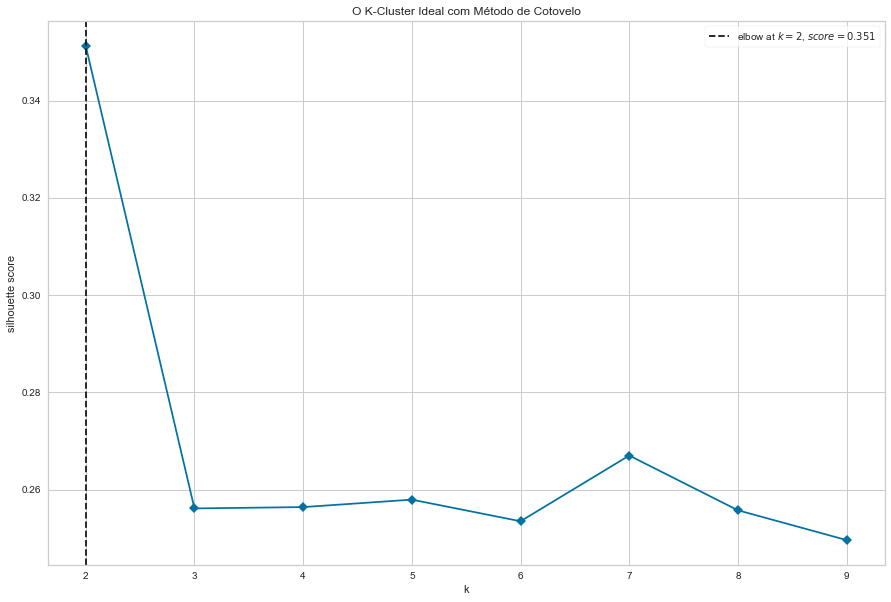

In [53]:
X_train_mista, X_valid_mista, X_test_mista = create_clustering(X_train_mista.copy(), 
                                                               X_valid_mista.copy(), 
                                                               X_test_mista.copy(), 
                                                               sc_                = Normalizer(norm='max'), 
                                                               gera_cluster       = True, 
                                                               trans_cluster_dammi= True)

## 3.4. Outliers

In [54]:
def outliers_create_feature(df_, col_):
        
    for col in col_:             
        Q1  = df_[col].quantile(0.25)
        Q3  = df_[col].quantile(0.75)
        IQR = Q3-Q1
        lowqe_bound=Q1 - 1.5 * IQR
        upper_bound=Q3 + 1.5 * IQR

        df_['fe_outliers_'+ col] = 0
        df_['fe_outliers_'+ col][(df_[col]<=lowqe_bound)|(df_[col]>=upper_bound)] = 1    
            
        df_[col] = np.where(df_[col] > df_[col].quantile(0.95), df_[col].median(), df_[col])

    return df_ 

In [55]:
cols = ['func_idade','contrato_salario']

X_train_dammies = outliers_create_feature(X_train_dammies, cols)
X_valid_dammies = outliers_create_feature(X_valid_dammies, cols)
X_test_dammies  = outliers_create_feature(X_test_dammies, cols)

In [56]:
X_train_mista = outliers_create_feature(X_train_mista, cols)
X_valid_mista = outliers_create_feature(X_valid_mista, cols)
X_test_mista  = outliers_create_feature(X_test_mista, cols)

In [57]:
def transf_contrato_salario(df_):

    df_['fe_contrato_salario_cat']= 'Acima 2000'
    df_['fe_contrato_salario_cat'][df_['contrato_salario'] <= 750] = 'até 750'
    df_['fe_contrato_salario_cat'][(df_['contrato_salario']>750) & (df_['contrato_salario']<=1100)] ='751 até 1100'
    df_['fe_contrato_salario_cat'][(df_['contrato_salario']>1100) & (df_['contrato_salario']<=1500)]='1101 até 1500'
    df_['fe_contrato_salario_cat'][(df_['contrato_salario']>1500) & (df_['contrato_salario']<=2000)]='1500 até 2000'

    df_.drop(['contrato_salario'], axis=1, inplace=True) 

    df_ = pd.get_dummies(df_, drop_first=True)
    
    return df_

In [58]:
X_train_dammies = transf_contrato_salario(X_train_dammies)
X_valid_dammies = transf_contrato_salario(X_valid_dammies)
X_test_dammies  = transf_contrato_salario(X_test_dammies)

In [59]:
X_train_mista = transf_contrato_salario(X_train_mista)
X_valid_mista = transf_contrato_salario(X_valid_mista)
X_test_mista  = transf_contrato_salario(X_test_mista)

In [60]:
X_train_mista.head()

,func_idade,func_racacor,func_uf,empresa_porte,empresa_setor,contrato_horastrabalho,IDH,densidade_demografica_hab_km2,fe_median,fe_quantile_25,fe_quantile_75,fe_dispersion_1,fe_tails,fe_media_sal_idade,func_sexo_MASCULINO,func_escolaridade_FUND_COMPLETO-MEDIO_INCOMPLETO,func_escolaridade_MEDIO COMPLETO,func_escolaridade_SUPERIOR_COMPLETO,func_escolaridade_SUPERIOR_INCOMPLETO,func_deficiencia_SIM,fe_cluster_1,fe_outliers_func_idade,fe_outliers_contrato_salario,fe_contrato_salario_cat_1500 até 2000,fe_contrato_salario_cat_751 até 1100,fe_contrato_salario_cat_Acima 2000,fe_contrato_salario_cat_até 750
10598,2.962496,0.365660,0.343315,0.401046,0.320608,44,0.682129,56.750000,44.0,26.000000,56.7500,1.430664,35.750000,371.419887,1,0,1,0,0,0,1,0,0,0,0,0,0
7096,2.843867,0.365660,0.425607,0.321249,0.410794,40,0.672852,89.625000,40.0,23.000000,89.6250,0.600586,32.593750,764.026607,1,0,0,1,0,0,1,0,0,0,0,1,0
5095,2.758924,0.270588,0.345822,0.291301,0.320608,24,0.660156,24.812500,24.0,21.000000,24.8125,6.281250,242.500000,336.062147,0,0,1,0,0,0,1,0,0,0,1,0,0
5922,3.141381,0.424907,0.425607,0.522480,0.410794,44,0.672852,89.625000,44.0,31.000000,89.6250,0.750488,30.546875,570.242888,0,0,0,1,0,0,1,0,0,1,0,0,0
13284,3.332222,0.365660,0.337864,0.300977,0.320608,44,0.645996,12.398438,37.0,12.398438,44.0000,1.170898,122.562500,1162.641656,1,0,0,0,1,0,1,0,1,0,0,1,0


# 4. Modelagem 

## 4.1. Pycaret linha de base

In [61]:
%time 
exp_clf101 = setup(data=df2_train, target=target, session_id=123) 

,Description,Value
0,session_id,123
1,Target,turnover_apos_1_ano
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(15000, 13)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,7
8,Ordinal Features,False
9,High Cardinality Features,False


In [62]:
%%time 
best_model = compare_models(sort = 'F1', n_select=7)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8288,0.9092,0.8680,0.7167,0.7850,0.6450,0.6533,0.3840
catboost,CatBoost Classifier,0.8331,0.9137,0.8343,0.7370,0.7825,0.6480,0.6515,2.1010
lightgbm,Light Gradient Boosting Machine,0.8310,0.9131,0.8407,0.7308,0.7818,0.6451,0.6494,0.2480
xgboost,Extreme Gradient Boosting,0.8292,0.9083,0.8126,0.7393,0.7741,0.6373,0.6394,0.6680
ada,Ada Boost Classifier,0.8185,0.8948,0.8428,0.7088,0.7698,0.6218,0.6284,0.1380
rf,Random Forest Classifier,0.8202,0.9028,0.7812,0.7363,0.7577,0.6150,0.6160,0.2860
knn,K Neighbors Classifier,0.7762,0.8497,0.7169,0.6793,0.6974,0.5200,0.5207,0.0810
dt,Decision Tree Classifier,0.7812,0.7614,0.6907,0.6987,0.6944,0.5241,0.5243,0.0390
et,Extra Trees Classifier,0.7518,0.8201,0.5835,0.6817,0.6284,0.4438,0.4471,0.3380
svm,SVM - Linear Kernel,0.6740,0.0000,0.6084,0.5341,0.5314,0.3107,0.3430,0.0380


Wall time: 1min 7s


In [63]:
print(best_model)

[GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False), <catboost.core.CatBoostClassifier object at 0x0000029716919F70>, LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
     

## 4.2. Criar um modelo

### 4.2.1. Gradient Boosting Classifier	

In [64]:
model_gbc = create_model('gbc', fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8229,0.9044,0.8624,0.7087,0.7780,0.6330,0.6414
1,0.8276,0.9099,0.8942,0.7056,0.7888,0.6466,0.6595
2,0.8429,0.9130,0.8862,0.7330,0.8024,0.6739,0.6823
3,0.8219,0.9044,0.8810,0.7011,0.7808,0.6341,0.6458
4,0.8371,0.9069,0.8889,0.7226,0.7972,0.6635,0.6735
5,0.8276,0.9126,0.8598,0.7174,0.7822,0.6415,0.6487
6,0.8257,0.9073,0.8439,0.7201,0.7771,0.6355,0.6409
7,0.8238,0.9191,0.8598,0.7112,0.7784,0.6344,0.6422
8,0.8105,0.8922,0.8280,0.7002,0.7588,0.6045,0.6103


### 4.2.3. Light Gradient Boosting Machine

In [65]:
model_lightgbm = create_model('lightgbm', fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8181,0.9072,0.8386,0.7092,0.7685,0.6204,0.6263
1,0.8286,0.9117,0.8651,0.7171,0.7842,0.6440,0.6518
2,0.8371,0.9148,0.8386,0.7424,0.7876,0.6563,0.6595
3,0.8333,0.9109,0.8571,0.7281,0.7874,0.6518,0.6577
4,0.8352,0.9182,0.8519,0.7335,0.7882,0.6546,0.6595
5,0.8229,0.9111,0.8254,0.7222,0.7704,0.6272,0.6309
6,0.8429,0.9125,0.8413,0.7518,0.7940,0.6676,0.6704
7,0.8333,0.9272,0.8439,0.7333,0.7847,0.6499,0.6541
8,0.8105,0.8935,0.8042,0.7086,0.7534,0.6005,0.6037


### 4.2.4. CatBoost Classifier

In [66]:
model_catboost = create_model('catboost', fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8286,0.9112,0.8466,0.7240,0.7805,0.6413,0.6465
1,0.8371,0.9156,0.8571,0.7347,0.7912,0.6590,0.6643
2,0.8476,0.9130,0.8704,0.7477,0.8044,0.6808,0.6860
3,0.8400,0.9126,0.8677,0.7354,0.7961,0.6659,0.6721
4,0.8305,0.9102,0.8175,0.7392,0.7764,0.6404,0.6425
5,0.8190,0.9154,0.8095,0.7217,0.7631,0.6175,0.6202
6,0.8352,0.9143,0.8095,0.7518,0.7796,0.6483,0.6495
7,0.8448,0.9279,0.8571,0.7483,0.7990,0.6735,0.6776
8,0.7990,0.8942,0.7778,0.6983,0.7359,0.5745,0.5767


### 4.2.4. Extreme Gradient Boosting

In [ ]:
model_xgboost = create_model('xgboost', fold=10)

## 4.3. Tune a Model

In [67]:
tuned_gbc = tune_model(model_gbc, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8267,0.9070,0.8122,0.7344,0.7714,0.6324,0.6344
1,0.8238,0.9051,0.8228,0.7249,0.7708,0.6286,0.6319
2,0.8333,0.9091,0.8228,0.7422,0.7804,0.6467,0.6489
3,0.8352,0.9083,0.8228,0.7458,0.7824,0.6503,0.6524
4,0.8238,0.9095,0.7963,0.7359,0.7649,0.6244,0.6256
5,0.8343,0.9094,0.8122,0.7488,0.7792,0.6469,0.6483
6,0.8362,0.9128,0.8095,0.7537,0.7806,0.6502,0.6512
7,0.8314,0.9170,0.8016,0.7481,0.7739,0.6398,0.6408
8,0.7857,0.8819,0.7381,0.6889,0.7126,0.5421,0.5429


In [68]:
tuned_lightgbm = tune_model(model_lightgbm, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8210,0.9020,0.8651,0.7047,0.7767,0.6299,0.6391
1,0.8333,0.9141,0.8783,0.7202,0.7914,0.6549,0.6638
2,0.8448,0.9115,0.8730,0.7416,0.8019,0.6757,0.6818
3,0.8390,0.9074,0.8757,0.7307,0.7966,0.6652,0.6727
4,0.8276,0.9069,0.8439,0.7234,0.7790,0.6391,0.6442
5,0.8171,0.9174,0.8254,0.7123,0.7647,0.6165,0.6210
6,0.8324,0.9082,0.8466,0.7306,0.7843,0.6484,0.6532
7,0.8295,0.9222,0.8333,0.7309,0.7787,0.6411,0.6447
8,0.8124,0.8941,0.8095,0.7100,0.7565,0.6050,0.6084


In [69]:
tuned_catboost = tune_model(model_catboost, optimize='F1')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8248,0.9067,0.8651,0.7109,0.7804,0.6369,0.6454
1,0.8305,0.9156,0.8757,0.7165,0.7881,0.6492,0.6582
2,0.8381,0.9094,0.8704,0.7311,0.7947,0.6627,0.6696
3,0.8219,0.9040,0.8624,0.7072,0.7771,0.6312,0.6399
4,0.8333,0.9062,0.8704,0.7231,0.7899,0.6537,0.6615
5,0.8286,0.9150,0.8492,0.7230,0.7810,0.6417,0.6473
6,0.8314,0.9067,0.8519,0.7269,0.7844,0.6474,0.6529
7,0.8324,0.9243,0.8519,0.7285,0.7854,0.6492,0.6546
8,0.8124,0.8914,0.8228,0.7052,0.7595,0.6072,0.6120


In [70]:
tuned_lightgbm = tune_model(model_lightgbm, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8210,0.9020,0.8651,0.7047,0.7767,0.6299,0.6391
1,0.8333,0.9141,0.8783,0.7202,0.7914,0.6549,0.6638
2,0.8448,0.9115,0.8730,0.7416,0.8019,0.6757,0.6818
3,0.8390,0.9074,0.8757,0.7307,0.7966,0.6652,0.6727
4,0.8276,0.9069,0.8439,0.7234,0.7790,0.6391,0.6442
5,0.8171,0.9174,0.8254,0.7123,0.7647,0.6165,0.6210
6,0.8324,0.9082,0.8466,0.7306,0.7843,0.6484,0.6532
7,0.8295,0.9222,0.8333,0.7309,0.7787,0.6411,0.6447
8,0.8124,0.8941,0.8095,0.7100,0.7565,0.6050,0.6084


In [77]:
tuned_xgboost = tune_model(model_xgboost, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8210,0.9020,0.8651,0.7047,0.7767,0.6299,0.6391
1,0.8333,0.9141,0.8783,0.7202,0.7914,0.6549,0.6638
2,0.8448,0.9115,0.8730,0.7416,0.8019,0.6757,0.6818
3,0.8390,0.9074,0.8757,0.7307,0.7966,0.6652,0.6727
4,0.8276,0.9069,0.8439,0.7234,0.7790,0.6391,0.6442
5,0.8171,0.9174,0.8254,0.7123,0.7647,0.6165,0.6210
6,0.8324,0.9082,0.8466,0.7306,0.7843,0.6484,0.6532
7,0.8295,0.9222,0.8333,0.7309,0.7787,0.6411,0.6447
8,0.8124,0.8941,0.8095,0.7100,0.7565,0.6050,0.6084


## 4.4. Plot a Model

In [79]:
evaluate_model(tuned_gbc)

,Parameters
ccp_alpha,0.0
criterion,friedman_mse
init,None
learning_rate,0.15
loss,deviance
max_depth,7
max_features,1.0
max_leaf_nodes,None
min_impurity_decrease,0.02
min_impurity_split,None


### 4.4.1. AUC

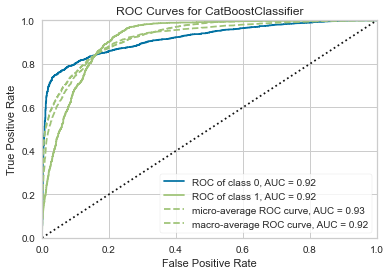

In [71]:
plot_model(tuned_catboost, plot='auc')

### 4.4.2. Precision-Recall Curve

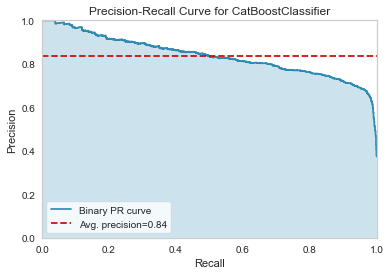

In [72]:
plot_model(tuned_catboost, plot = 'pr')

### 4.4.3. Feature Importance Plot

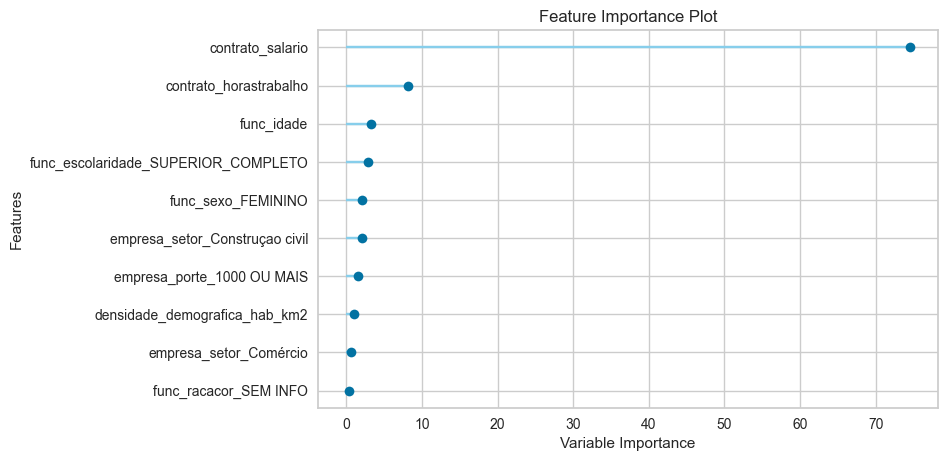

In [73]:
plot_model(tuned_catboost, plot='feature')

### 4.4.4. Confusion Matrix

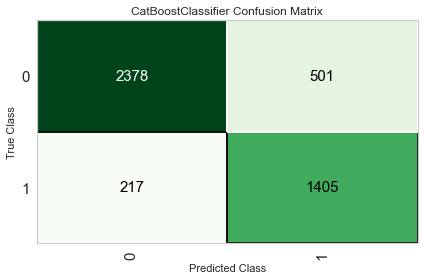

In [74]:
plot_model(tuned_catboost, plot = 'confusion_matrix')

Outra maneira de analisar o desempenho dos modelos é usar a função assessment_model() que exibe uma interface de usuário para todos os gráficos disponíveis para um determinado modelo. Ele usa internamente a função plot_model()

## 4.5. Prever no teste / amostra de retenção
Antes de finalizar o modelo, é aconselhável realizar uma verificação final prevendo o conjunto de teste/hold-out e revisando as métricas de avaliação. Se você observar a grade de informações na Seção 6 acima, verá que 30% (6.841 amostras) dos dados foram separados como amostra de teste/hold-out. Todas as métricas de avaliação que vimos acima são resultados de validação cruzada com base apenas no conjunto de treinamento (70%). Agora, usando nosso modelo final treinado armazenado na variáveltuned_rf, faremos previsões em relação à amostra de retenção e avaliaremos as métricas para ver se elas são materialmente diferentes dos resultados do CV.

In [80]:
predict_model(tuned_catboost);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8405,0.9177,0.8662,0.7371,0.7965,0.6667,0.6726


A precisão no conjunto de teste/resistência é de 0,8116 em comparação com 0,8203 alcançada nos resultados de CV de tun_rf (na seção 9.3 acima). Esta não é uma diferença significativa. Se houver uma grande variação entre os resultados do teste/hold-out e do CV, isso normalmente indicaria um ajuste excessivo, mas também pode ser devido a vários outros fatores e exigiria investigação adicional. Nesse caso, avançaremos com a finalização do modelo e a previsão de dados não vistos (os 5% que separamos no início e nunca expusemos ao PyCaret).

(DICA: É sempre bom observar o desvio padrão dos resultados de CV ao usar create_model().)

## 4.6. Finalizar modelo para implantação
A finalização do modelo é a última etapa do experimento. Um fluxo de trabalho normal de aprendizado de máquina no PyCaret começa com setup(), seguido pela comparação de todos os modelos usando compare_models() e listando alguns modelos candidatos (com base na métrica de interesse) para executar várias técnicas de modelagem, como ajuste de hiperparâmetros, ensembling, empilhamento etc. . Esse fluxo de trabalho acabará levando você ao melhor modelo para usar na previsão de dados novos e não vistos. A função finalize_model() ajusta o modelo ao conjunto de dados completo, incluindo a amostra de teste/hold-out (30% neste caso). O objetivo dessa função é treinar o modelo no conjunto de dados completo antes de ser implantado na produção.

In [81]:
final_rf = finalize_model(tuned_catboost)

In [ ]:
#Final Random Forest model parameters for deployment
print(tuned_catboost)

Atenção: Uma palavra final de cautela. Depois que o modelo é finalizado usando finalize_model(), todo o conjunto de dados, incluindo o conjunto de teste/hold-out, é usado para treinamento. Dessa forma, se o modelo for usado para previsões no conjunto de retenção após o uso de finalize_model(), a grade de informações impressa será enganosa, pois você está tentando prever nos mesmos dados que foram usados para modelagem. Para demonstrar apenas este ponto, usaremos final_rf em predict_model() para comparar a grade de informações com a acima na seção 11.

In [82]:
predict_model(final_rf);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8507,0.9308,0.8792,0.7497,0.8093,0.6879,0.6938


Observe como o AUC em final_rf aumentou para 0,7526 de 0,7407, mesmo que o modelo seja o mesmo. Isso ocorre porque a variável final_rf foi treinada no conjunto de dados completo, incluindo o conjunto test/hold-out.

## 4.7. Prever dados não vistos
A função predict_model() também é usada para prever no conjunto de dados não visto. A única diferença da seção 11 acima é que desta vez passaremos o parâmetro data_unseen. data_unseen é a variável criada no início do tutorial e contém 5% (1200 amostras) do conjunto de dados original que nunca foi exposto ao PyCaret. (veja a seção 5 para explicação)

In [83]:
unseen_predictions = predict_model(final_rf, data=X_test)
unseen_predictions.head()

,func_sexo,func_idade,func_racacor,func_escolaridade,func_uf,func_deficiencia,empresa_porte,empresa_setor,contrato_horastrabalho,contrato_salario,IDH,densidade_demografica_hab_km2,Label,Score
0,FEMININO,30,PRETA-PARDA,MEDIO COMPLETO,MA,NAO,ATE 4,Comércio,44,1583.00,0.639,19.81,1,0.7839
1,MASCULINO,25,PRETA-PARDA,MEDIO COMPLETO,MA,NAO,1000 OU MAIS,Serviços,36,1497.00,0.639,19.81,1,0.7952
2,FEMININO,32,SEM INFO,FUND_COMPLETO-MEDIO_INCOMPLETO,MA,NAO,DE 20 A 49,Comércio,12,356.75,0.639,19.81,0,0.9896
3,FEMININO,24,SEM INFO,SUPERIOR_COMPLETO,MA,NAO,DE 10 A 19,Comércio,44,1149.00,0.639,19.81,0,0.9880
4,MASCULINO,26,PRETA-PARDA,ANALFABETO-FUND_INCOMPLETO,MA,NAO,DE 50 A 99,Serviços,44,931.50,0.639,19.81,0,0.9910


As colunas Label e Score são adicionadas ao conjunto data_unseen. Rótulo é a previsão e pontuação é a probabilidade da previsão. Observe que os resultados previstos são concatenados ao conjunto de dados original enquanto todas as transformações são executadas automaticamente em segundo plano. Você também pode verificar as métricas sobre isso, pois tem o padrão da coluna de destino real disponível. Para fazer isso, usaremos o módulo pycaret.utils. Veja exemplo abaixo:

In [ ]:
from pycaret.utils import check_metric
check_metric(unseen_predictions['default'], unseen_predictions['Label'], metric = 'F1') 
# https://github.com/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20Level%20Beginner%20-%20%20CLF101.ipynb

In [ ]:
unseen_predictions


In [ ]:
df_sub = X_test.copy()
df_sub[target] = unseen_predictions.Label.map({1:'SIM', 0:'NAO'})

df_sub[target].to_csv(path + 'Data/submission/catboost.csv', index = False)


In [86]:
%%time

seed   = 12359
params       = {'objective'        : 'binary:logistic',    
                'eval_metric'      : 'auc',                                 
                'random_state'     : seed}

params_mista = {'objective'        : 'binary:logistic',    
                'eval_metric'      : 'auc',  
                'max_depth'        : 7, 
                'learning_rate'    : 0.1,       
                'n_estimators'     : 100, 
                'scale_pos_weight' : 1.77726,                
                'random_state'     : seed}
     
params_dami = {'objective'        : 'binary:logistic',   
               'eval_metric'      : 'auc',         
               'learning_rate'    : 0.03,               
               'max_depth'        : 6,
               'n_estimators'     : 200, 
               'scale_pos_weight' : 1.77726,          
               'random_state'     : seed}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'})

scaler   = Normalizer(norm='max')
df_dammi = [X_train_dammies, y_train, X_valid_dammies, y_valid, X_test_dammies, 'Dammi', params_dami]  
df_misto = [X_train_mista, y_train, X_valid_mista, y_valid, X_test_mista, 'Mista', params_mista]

models = [ xgb.XGBClassifier(**params)]

for model in models: 

    model_name      = str(model)        
    model_name      = model_name[:model_name.index('(')]
        
    print()
    print (model_name)
    
    for df in ([df_misto, df_dammi]):
        cols       = df[0].columns     
        X_train_sc = pd.DataFrame(scaler.fit_transform(df[0][cols]) , columns=cols)
        X_valid_sc = pd.DataFrame(scaler.transform(df[2][cols]), columns=cols)
        X_test_sc  = pd.DataFrame(scaler.transform(df[4][cols]), columns=cols)
        params     = df[6]

        model.fit(X_train_sc, y_train)

        y_pred = model.predict(X_valid_sc)
        f1     = metrics.f1_score(y_valid, y_pred)

        print ('F1-score: {:2.5f} - {}'.format(f1, df[5]))

print()

#del X_train_sc, X_valid_sc, X_test_sc

# F1-score: 0.78901 - Dammi
# F1-score: 0.78924 - Mista    


XGBClassifier
F1-score: 0.76652 - Mista
F1-score: 0.77239 - Dammi

Wall time: 2.77 s


In [87]:
cls = cls.Classification(predictor ='lr',params={'max_iter':5000})
cls.predictor(X_train_dammies, y_train)
#.predict(X_train_dammies, y_train)
#accuracy_scores[classifier_name] = accuracy

NameError: name 'cls' is not defined

In [ ]:
model = xgb.XGBClassifier(**params_dami)
pipe_scaler = Pipeline(steps = [('scaler', Normalizer(norm='max'))])
pipe_model  = Pipeline(steps = [('Preprocessing', pipe_scaler), ('model', model)])
scoring     = ['f1']

scores = cross_validate(pipe_model, 
                        X_train_dammies, 
                        y_train, 
                        scoring            = scoring, 
                        return_train_score = True,                         
                        cv                 = 5
                       )

y_pred = cross_val_predict(estimator = pipe_model, 
                           X         = X_valid_dammies, 
                           y         = y_valid, 
                           method='predict_proba', 
                           cv = 5)
y_pred_prob = y_pred[:,1]

#metrics.f1_score(y_valid, y_pred)
# 0.7786499215070644

In [ ]:
rf = RandomForestClassifier()
lr = LogisticRegression()
xb = xgb.XGBClassifier(**params_mista)

rf_probas = rf.fit(X_train_dammies , y_train).predict_proba(X_valid_dammies)
lr_probas = lr.fit(X_train_dammies, y_train).predict_proba(X_valid_dammies)
xg_probas = xb.fit(X_train_dammies, y_train).predict_proba(X_valid_dammies)

clf_names = ['Random Forest', 'Logistic Regression']
probas_list = [rf_probas, lr_probas]

clf_names = ['Random Forest','XGB']
probas_list = [rf_probas, xg_probas]


skplt.metrics.plot_calibration_curve(y_valid,
                                      probas_list,
                                      clf_names);

In [ ]:
x_, y_ = calibration_curve(y_valid, xg_probas[:,1], n_bins = 10, normalize = True)

# Plot calibration curve
 
# Plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated');
# Plot model's calibration curve
plt.plot(y_, x_, marker = 'o', label = 'XGB')
 
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()

## Cross-validated version

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=1234)

# store probability predictions and true labels here
logreg_kfold_probability = []
rf_kfold_probability     = []
kfold_true_label         = []
kfold_xgb_prob = []

feature_cols = X_train_dammies.columns

for train_index, validate_index in kf.split(X_train_dammies):
    
    X_tr, X_vl = X_train_dammies.iloc[train_index], X_train_dammies.iloc[validate_index]
    y_tr, y_vl = y_train.iloc[train_index], y_train.iloc[validate_index]
        
    model_lr = LogisticRegression().fit(X_tr ,y_tr)
    model_rf     = RandomForestClassifier().fit(X_tr, y_tr)
    model_xgb    = xgb.XGBClassifier(**params_dami).fit(X_tr, y_tr)
    
    logreg_kfold_probability.append(model_lr.predict_proba(X_vl)[:,1])
    rf_kfold_probability.append(model_rf.predict_proba(X_vl)[:,1])    
    kfold_xgb_prob.append(model_xgb.predict_proba(X_vl)[:,1]) 
    
    kfold_true_label.append(y_vl)    

In [ ]:
logreg_kfold_probability_stacked = np.hstack(logreg_kfold_probability)
rf_kfold_probability_stacked     = np.hstack(rf_kfold_probability)
kfold_true_label_stacked         = np.hstack(kfold_true_label)
kfold_xgb_stacked  = np.hstack(kfold_xgb_prob)
                                     
logreg_y, logreg_x = calibration_curve(kfold_true_label_stacked, logreg_kfold_probability_stacked, n_bins=10)
rf_y, rf_x         = calibration_curve(kfold_true_label_stacked, rf_kfold_probability_stacked, n_bins=10)
xgb_y, xgb_x       = calibration_curve(kfold_true_label_stacked, kfold_xgb_stacked, n_bins=10)



In [ ]:
# calibration curves
fig, ax = plt.subplots(figsize=(9,5))
plt.plot(logreg_x,logreg_y, marker='o', linewidth=1, label='logreg')
plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='rf')
plt.plot(xgb_y, xgb_x , marker='o', linewidth=1, label='xgb')


# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for Titanic data')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show() # it's not rendered correctly on GitHub, check blog post for actual pic

In [ ]:
def plot_calibration_curve(est, name, fig_index):
    
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        
        clf.fit(X_train_dammies, y_train)
        y_pred = clf.predict(X_valid_dammies)
        
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_valid_dammies)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_valid_dammies)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = metrics.brier_score_loss(y_valid, prob_pos, pos_label=y.max())
        
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % metrics.precision_score(y_valid, y_pred))
        print("\tRecall: %1.3f" % metrics.recall_score(y_valid, y_pred))
        print("\tF1: %1.3f\n" % metrics.f1_score(y_valid, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_valid, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()


# Plot calibration curve for Linear SVC
plot_calibration_curve(xgb.XGBClassifier(**params), "SVC", 2)

plt.show()

In [ ]:
scores['test_f1'].mean(), scores['train_f1'].mean()




In [ ]:
pipe_.fit(X_train_dammies, y_train)
y_pred = pipe_.predict(X_valid_dammies)
metrics.f1_score(y_valid, y_pred)
# 0.7897595034910784

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split, cross_validate

model = xgb.XGBClassifier(**params)
pipe_scaler = Pipeline(steps = [('scaler', Normalizer(norm='max'))])

pipe_ = Pipeline(steps = [('Preprocessing', pipe_scaler), ('model', model)])
scoring = ['f1']

scores = cross_validate(pipe_, X_train_mista, y_train, scoring=scoring, return_train_score = True, cv = 5)

y_pred = cross_val_predict(pipe_, X_valid_mista, y_valid, cv = 5)

metrics.f1_score(y_valid, y_pred)
# 0.7794871794871796

In [ ]:
pipe_.fit(X_train_mista, y_train)
y_pred = pipe_.predict(X_valid_mista)
metrics.f1_score(y_valid, y_pred)
# 0.7897595034910784

In [ ]:
%%time 

from sklearn.model_selection import GridSearchCV

params = {
    'model__num_leaves': [7, 14, 21, 28, 31, 50],
    'model__learning_rate': [0.1, 0.03, 0.003, 0.2, 0.15],
    'model__max_depth': [1, 3, 5, 7 ],
    'model__n_estimators': [50, 100, 200, 500],
    'model__objective'   : ['binary:logistic'], 
    'model__scale_pos_weight' : [1.77726], 
    'model__random_state'     : [seed], 
    'model__eval_metric=': ['auc'], 

    
}

model = xgb.XGBClassifier()
pipe_scaler = Pipeline(steps = [('scaler', Normalizer(norm='max'))])

pipe_ = Pipeline(steps = [('Preprocessing', pipe_scaler), ('model', model)])
scoring = ['f1']

grid_search = GridSearchCV(pipe_, params, scoring='f1', cv=5)
grid_search.fit(X_train_dammies, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.cv_results_["mean_test_score"])

mista = {'model__eval_metric=': 'auc', 'model__learning_rate': 0.1, 
         'model__max_depth': 5, 'model__n_estimators': 100, 
         'model__num_leaves': 7, 'model__objective': 'binary:logistic', 
         'model__random_state': 12359, 'model__scale_pos_weight': 1.77726} # 0.7900638667484837





In [ ]:
%%time 

from sklearn.model_selection import GridSearchCV

params = {
    'model__num_leaves': [7, 14, 21, 28, 31, 50],
    'model__learning_rate': [0.1, 0.03, 0.003, 0.2, 0.15],
    'model__max_depth': [1, 3, 5, 7 ],
    'model__n_estimators': [50, 100, 200, 500],
    'model__objective'   : ['binary:logistic'], 
    'model__scale_pos_weight' : [1.77726], 
    'model__random_state'     : [seed], 
    'model__eval_metric=': ['auc'], 

    
}

model = xgb.XGBClassifier()
pipe_scaler = Pipeline(steps = [('scaler', Normalizer(norm='max'))])

pipe_ = Pipeline(steps = [('Preprocessing', pipe_scaler), ('model', model)])
scoring = ['f1']

grid_search = GridSearchCV(pipe_, params, scoring='f1', cv=5)
grid_search.fit(X_train_mista, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.cv_results_["mean_test_score"])


### 3.1.2. Feature Importances  

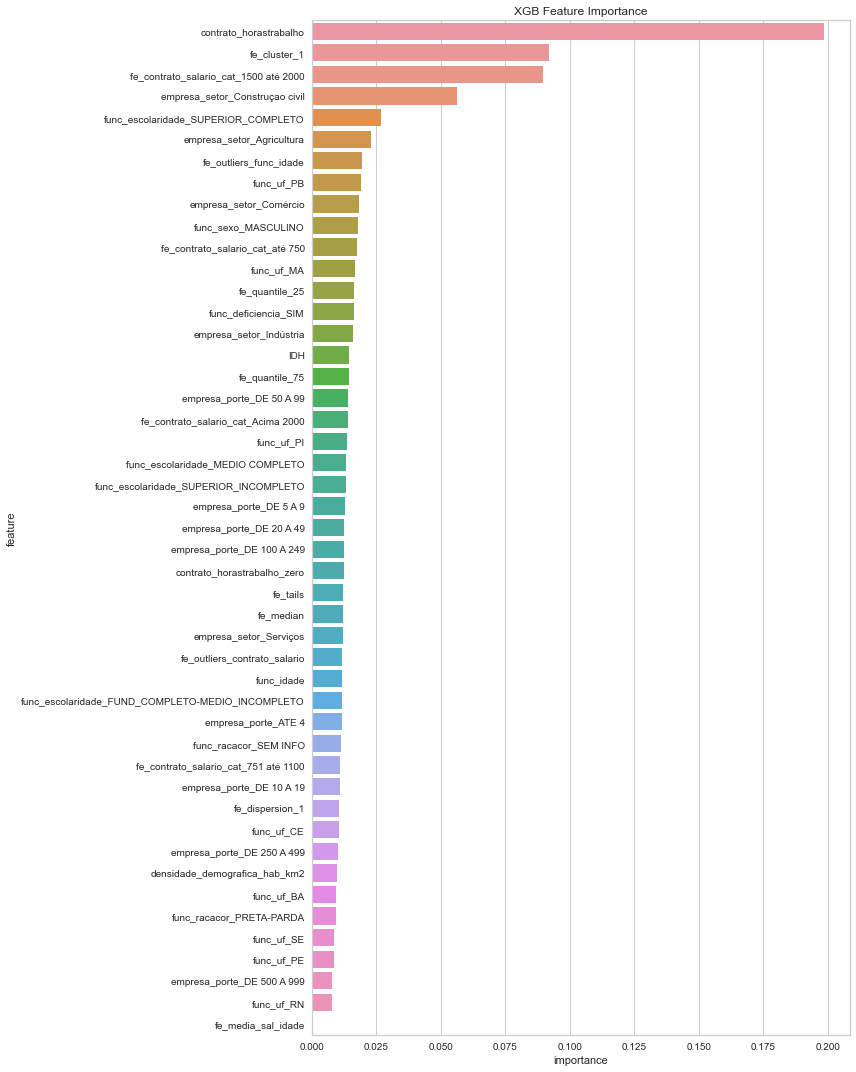

In [88]:
df_imp = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})

plt.figure(figsize=(12, 15))
sns.barplot(x="importance", 
            y="feature", 
            data=df_imp.sort_values(by="importance", ascending=False).iloc[:55])

plt.title("XGB Feature Importance")
plt.tight_layout()

plt.show()

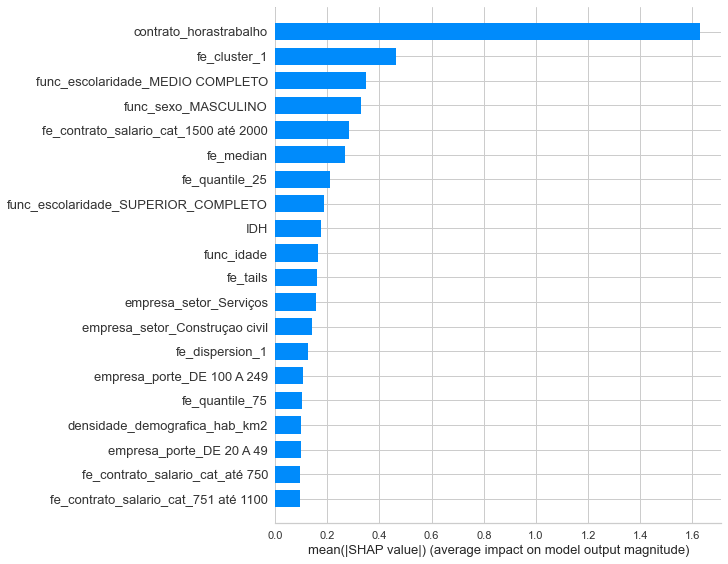

In [89]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_sc)
shap.summary_plot(shap_values, X_train_sc, plot_type="bar")

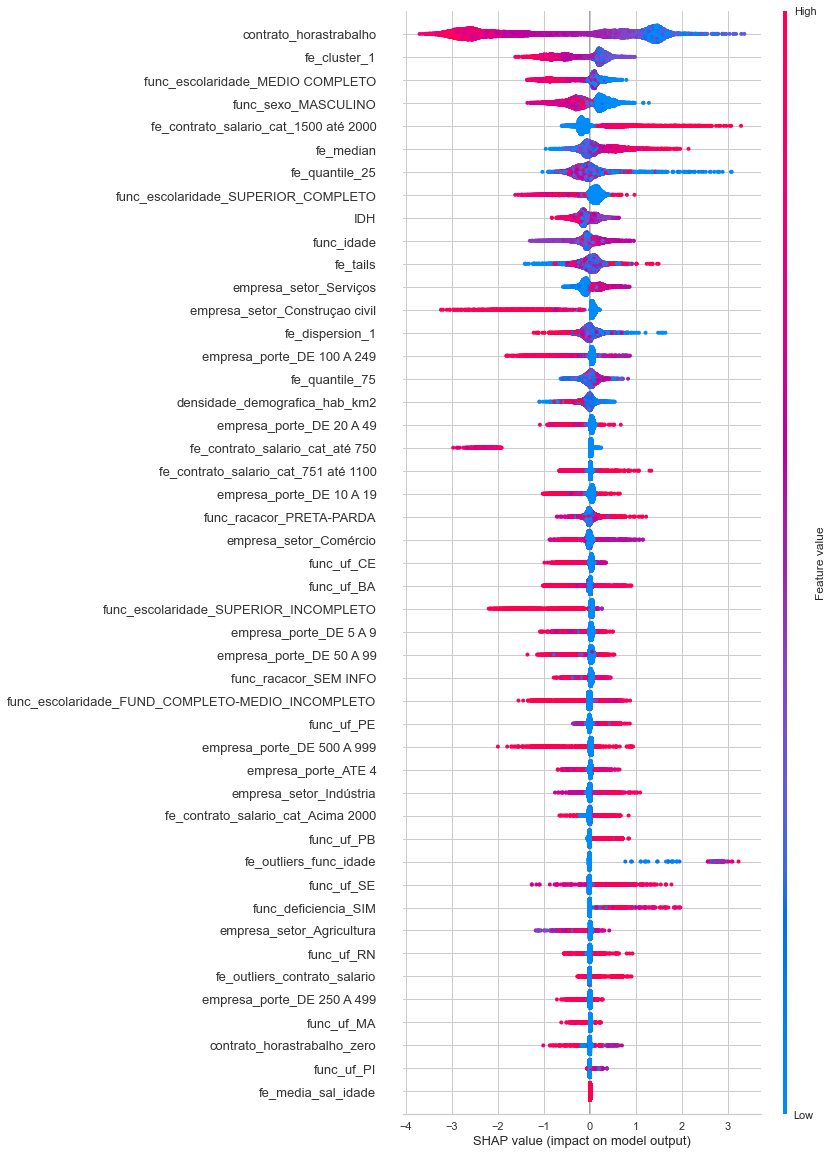

In [90]:
shap.summary_plot(shap_values, X_train_sc, max_display=50)

# https://www.kaggle.com/code/stevenrferrer/tps-september-2021-blend-lgb-xgb-cb-hgb-voting
# https://www.kaggle.com/code/hrshuvo/tps-0921-stack-blend
# https://www.kaggle.com/code/vishwas21/tps-sep-21-3-level-custom-stacking

# Voting Classifier
# https://www.kaggle.com/code/dlaststark/tps-sep-voting-classifier


# <div class="alert alert-success"> 3. FEATURE SELECTION </div>

## 3.1. Boruta

In [92]:
from boruta  import BorutaPy

In [100]:
sc   = Normalizer(norm='max')
X_train_dammies_sc = pd.DataFrame(sc.fit_transform(X_train_dammies), columns=X_train_dammies.columns)
X_train_mista_sc   = pd.DataFrame(sc.fit_transform(X_train_mista), columns=X_train_mista.columns)

In [106]:
model = xgb.XGBClassifier(**params_dami)

feat_sel_dami = BorutaPy(model, 
                         n_estimators = 'auto', 
                         two_step     = False,
                         verbose      = 2, 
                         max_iter     = 100,
                         random_state = 42)


feat_sel_dami.fit(X_train_dammies_sc.values, y_train.values)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	47
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	47
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	47
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	47
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	47
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	47
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	47
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	47
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	47
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	10
Tentative: 	22
Rejected: 	15
Iteration: 	11 / 100
Confirmed: 	10
Tentative: 	22
Rejected: 	15
Iteration: 	12 / 100
Confirmed: 	10
Tentative: 	22
Rejected: 	15
Iteration: 	13 / 100
Confirmed: 	10
Tentative: 	22
Rejected: 	15
Iteration: 	14 / 100
Confirmed: 	10
Tentative: 	22
Rejected: 	15
Iteration: 	15 / 100
Confirmed: 	10
Tentative: 	22
Rejected: 	15
Iteration: 	16 / 100
Confirmed: 	10
Tentative: 	22
R

BorutaPy(alpha=0.05,
         estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                 colsample_bylevel=1, colsample_bynode=1,
                                 colsample_bytree=1, eval_metric='auc', gamma=0,
                                 gpu_id=-1, importance_type='gain',
                                 interaction_constraints='', learning_rate=0.03,
                                 max_delta_step=0, max_depth=6,
                                 min_child_weight=1, missing=nan,
                                 monotone_constraints='()', n_estimators=113,
                                 n_jobs=8, num_parallel_tree=1,
                                 objective='binary:logistic',
                                 random_state=1067430296, reg_alpha=0,
                                 reg_lambda=1, scale_pos_weight=1.77726,
                                 subsample=1, tree_method='exact',
                                 use_label_encoder=True, valida

In [108]:
feat_sel_dami

BorutaPy(alpha=0.05,
         estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                 colsample_bylevel=1, colsample_bynode=1,
                                 colsample_bytree=1, eval_metric='auc', gamma=0,
                                 gpu_id=-1, importance_type='gain',
                                 interaction_constraints='', learning_rate=0.03,
                                 max_delta_step=0, max_depth=6,
                                 min_child_weight=1, missing=nan,
                                 monotone_constraints='()', n_estimators=113,
                                 n_jobs=8, num_parallel_tree=1,
                                 objective='binary:logistic',
                                 random_state=1505517686, reg_alpha=0,
                                 reg_lambda=1, scale_pos_weight=1.77726,
                                 subsample=1, tree_method='exact',
                                 use_label_encoder=True, valida

In [ ]:

feat_sel_mista = BorutaPy(model, 
                         n_estimators = 'auto', 
                         two_step     = False,
                         verbose      = 2, 
                         max_iter     = 100,
                         random_state = 42)


feat_sel_mista.fit(X_train_mista_sc.values, y_train.values)


In [111]:
X_train_selected_d = X_train_dammies_sc.iloc[:,feat_sel_dami.support_]
X_test_selected_d  = X_train_dammies_sc.iloc[:,feat_sel_dami.support_]
X_train_selected_d.columns

Index(['func_idade', 'contrato_horastrabalho', 'IDH', 'fe_quantile_25',
       'func_sexo_MASCULINO', 'func_escolaridade_MEDIO COMPLETO',
       'func_escolaridade_SUPERIOR_COMPLETO',
       'func_escolaridade_SUPERIOR_INCOMPLETO', 'func_deficiencia_SIM',
       'empresa_setor_Agricultura', 'empresa_setor_Comércio',
       'empresa_setor_Construçao civil', 'empresa_setor_Serviços',
       'fe_cluster_1', 'fe_outliers_func_idade',
       'fe_contrato_salario_cat_1500 até 2000',
       'fe_contrato_salario_cat_Acima 2000',
       'fe_contrato_salario_cat_até 750'],
      dtype='object')

In [110]:

X_train_selected_m = X_train_dammies_sc.iloc[:,feat_sel_mista.support_]
X_test_selected_m  = X_train_dammies_sc.iloc[:,feat_sel_mista.support_]


NameError: name 'feat_sel_mista' is not defined

In [ ]:



X_test_selected.shape , X_test_selected.shape

In [102]:
X_train_selected.head()

,func_idade,contrato_horastrabalho,fe_median,fe_quantile_25,fe_quantile_75,fe_media_sal_idade,func_sexo_MASCULINO,func_racacor_SEM INFO,func_escolaridade_SUPERIOR_COMPLETO,func_escolaridade_SUPERIOR_INCOMPLETO,func_uf_PB,func_deficiencia_SIM,empresa_setor_Agricultura,empresa_setor_Comércio,empresa_setor_Construçao civil,fe_outliers_func_idade,fe_outliers_contrato_salario,fe_contrato_salario_cat_1500 até 2000,fe_contrato_salario_cat_até 750
0,0.007976,0.118464,0.118464,0.070002,0.152792,1.0,0.002692,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.002692,0.0,0.0,0.00000,0.000000,0.0
1,0.003722,0.052354,0.052354,0.030104,0.117306,1.0,0.001309,0.000000,0.001309,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0
2,0.008210,0.071415,0.071415,0.062488,0.073833,1.0,0.000000,0.002976,0.000000,0.00000,0.0,0.0,0.0,0.002976,0.0,0.0,0.00000,0.000000,0.0
3,0.005509,0.077160,0.077160,0.054363,0.157170,1.0,0.000000,0.000000,0.001754,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.001754,0.0
4,0.002866,0.037845,0.031824,0.010664,0.037845,1.0,0.000860,0.000000,0.000000,0.00086,0.0,0.0,0.0,0.000860,0.0,0.0,0.00086,0.000000,0.0


<div class="alert alert-info" role="alert">
    
**`NOTA:`** <br>
Podemos observar acima no gráfico de importância das variáveis, que temos 3 variáveis que criamos entre as 25 primeiras variáveis, vamos fazer uma validação cruzada e armazenar a importância das variáveis em cada fold, para termos uma ideia de como essas variáveis se comportam. 
    
</div>

### 3.1.2. Validação cruzada

In [ ]:
def save_data_model(model_, model_name_, path_, y_pred_train_prob_, y_pred_test_prob_, y_pred_test_, score_, seed_, level_='1', target_='target'):    
    
    level = 'n' + level_ + '/'

    if score_>.6:    
        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_train = path_ + 'model/preds/train/' + level + model_name_.format(score_, seed_)  + '.pkl.z'
        path_name_test  = path_ + 'model/preds/test/'  + level + model_name_.format(score_, seed_)  + '.pkl.z'   
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_)  + '.pkl.z'   
        
        jb.dump(y_pred_train_prob_, path_name_train)
        jb.dump(y_pred_test_prob_, path_name_test)
        jb.dump(model_, path_name_model)

In [ ]:
def model_fit(model_, model_type_, X_trn, y_trn, X_val, y_val, n_estimators):

    if model_type_==1:       
        model_.fit(X_trn, y_trn)
    else:
        if model_type_==2: 
            model_.fit(X_trn, y_trn,
                        eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
                        early_stopping_rounds = int(n_estimators*.2),
                        verbose               = False)      
            
    return model_

In [ ]:
from sklearn.linear_model      import LogisticRegression
from sklearn.neighbors         import KNeighborsClassifier 
from sklearn.tree              import DecisionTreeClassifier 
from sklearn.ensemble          import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from lightgbm                  import LGBMClassifier
from sklearn.neural_network    import MLPClassifier 
from sklearn.linear_model      import RidgeClassifier
from sklearn.svm               import SVC, LinearSVC, NuSVC

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


mlp_modelo = MLPClassifier(hidden_layer_sizes = (5, 3 ), 
                           activation         = 'relu', 
                           batch_size         = 64, 
                           learning_rate      = 'constant', 
                           learning_rate_init = 0.01, 
                           max_iter           = 200, 
                           early_stopping     = True, 
                           n_iter_no_change   = 50, 
                           random_state       = 10)

In [ ]:
def model_train_cross_val(models_, X_, y_, X_test_, scalers_=[None], fold_=5, model_type_=2, path_='', 
                          model_stacking_=None, feature_scaler_=None, print_report_=False, seed_=12359,
                          target_='target', generate_sub_=False, threshold=.5): 

    score           = []    
    model           = []     
    score_best      = 0 
    model_num_best  = 0 
    model_best      = ''
    taco            = 76
    col_prob        = y_.sort_values().unique()

    df_prob      = pd.DataFrame() 
    df_feat_imp  = pd.DataFrame()
    df_pred_test = pd.DataFrame()

    for model_num, model_ in enumerate(models_):

        try:
            n_estimators    = model_.get_params()['n_estimators']
            n_estimator_str = '- n_estimators: {}'.format(n_estimators)
        except:
            n_estimator_str = ''
            model_type_     = 1

        for i, scaler_ in enumerate(scalers_): 

            oof_preds_test  = 0
            time_start      = datetime.now()
            score           = []  
            preds           = [] 
            model_name      = str(model_)        
            model_name      = model_name[:model_name.index('(')]
                
            if scaler_!=None:            
                string_scaler = str(scaler_)        
                string_scaler = string_scaler[:string_scaler.index('(')]
            else:
                string_scaler = None 
                
            y_pred_test = np.zeros(len(X_test_))

            #folds = KFold(n_splits=fold_, shuffle=True, random_state=seed_)
            folds = StratifiedKFold(n_splits=fold_,  shuffle=True, random_state=seed_)
            
            print('='*taco)
            print('Model: {} - Scaler: {} {}'.format(model_name, string_scaler, n_estimator_str))
            print('='*taco)

            for fold, (trn_idx, val_idx) in enumerate(folds.split(X_, y_, groups=y_)): 

                time_fold_start = datetime.now()

                # ---------------------------------------------------- 
                # Separar dados para treino 
                # ----------------------------------------------------     
                X_trn, X_val = X_.iloc[trn_idx], X_.iloc[val_idx]
                y_trn, y_val = y_.iloc[trn_idx], y_.iloc[val_idx] 

                # ---------------------------------------------------- 
                # Processamento 
                # ----------------------------------------------------     
                if scaler_!=None: 
                    X_tst = X_test_.copy()
                    if feature_scaler_!=None:                     
                        X_trn[feature_scaler_] = scaler_.fit_transform(X_trn[feature_scaler_])
                        X_val[feature_scaler_] = scaler_.transform(X_val[feature_scaler_])                      
                        X_tst[feature_scaler_] = scaler_.transform(X_tst[feature_scaler_])
                    else:            
                        X_trn = pd.DataFrame(scaler_.fit_transform(X_trn), columns=X_trn.columns)
                        X_val = pd.DataFrame(scaler_.transform(X_val), columns=X_trn.columns)
                        X_tst = pd.DataFrame(scaler_.transform(X_test_.copy()), columns=X_trn.columns)
                        
                # ---------------------------------------------------- 
                # Treinar o modelo 
                # ---------------------------------------------------- 
                if  model_stacking_ is not None: 
                    model_stacking = model_fit(model_stacking_, 1,  X_trn, y_trn, X_val, y_val, n_estimators)            
                    X_trn['pred_stacking'] = model_stacking.predict_proba(X_trn)[:,1]
                    X_val['pred_stacking'] = model_stacking.predict_proba(X_val)[:,1]
                    X_tst['pred_stacking'] = model_stacking.predict_proba(X_tst)[:,1]
                    
                model_ = model_fit(model_, model_type_, X_trn, y_trn, X_val, y_val, n_estimators )
                    
                # ---------------------------------------------------- 
                # Predição 
                # ----------------------------------------------------     
                #y_pred_val      = model_.predict(X_val) #, ntree_limit=model_.best_ntree_limit)    
                y_pred_val_prob = model_.predict_proba(X_val) #, ntree_limit=model_.best_ntree_limit) #[:, 1] 
                y_pred_val      = (y_pred_val_prob[:,1]>threshold).astype(int)

                
                oof_preds_test += model_.predict_proba(X_tst)[:, 1] / folds.n_splits

                preds.append(model_.predict(X_tst))            

                df_prob_temp    = pd.DataFrame(y_pred_val_prob, columns=col_prob)
                y_pred_pbro_max = df_prob_temp.max(axis=1)

                df_prob_temp['fold']    = fold+1
                df_prob_temp['id']      = val_idx    
                df_prob_temp['y_val']   = y_val.values
                df_prob_temp['y_pred']  = y_pred_val            
                df_prob_temp['y_proba'] = np.max(y_pred_val_prob, axis=1)
                df_prob_temp['model']   = model_name 
                df_prob_temp['scaler']  = str(string_scaler)
                
                df_prob = pd.concat([df_prob, df_prob_temp], axis=0)     
                df_prob.sort_values(by=['id'], inplace=True) 
                
                # ---------------------------------------------------- 
                # Score 
                # ---------------------------------------------------- 
                f1    = metrics.f1_score(y_val, y_pred_val) 
                acc   = metrics.accuracy_score(y_val, y_pred_val)    
                lloss = metrics.log_loss (y_val, y_pred_val)
                
                score.append(f1)     

                # ---------------------------------------------------- 
                # Feature Importance
                # ----------------------------------------------------             
                #df_feat_imp_temp = pd.DataFrame(index   = X_val.columns,
                #                                data    = model_.feature_importances_,
                #                                columns = ['fold_{}'.format(fold+1)])

                #df_feat_imp_temp['score_'+str(fold+1)] = np.round(f1, 5)
                #df_feat_imp = pd.concat([df_feat_imp, df_feat_imp_temp], axis=1)
                    
                # ---------------------------------------------------- 
                # Print resultado  
                # ---------------------------------------------------- 
                time_fold_end = diff(time_fold_start, datetime.now())
                msg = '[Fold {}] F1-score: {:2.5f} - ACC: {:2.5f} - L. Loss: {:2.5f}  - {}'
                print(msg.format(fold+1, f1, acc,  lloss, time_fold_end))
                
            # ---------------------------------------------------- 
            # Salva o modelo e média do score
            # ----------------------------------------------------     
            score_mean = np.mean(score) 
            score_std  = np.std(score)

            model.append({'model': model_, 'scaler': scaler_, 'score': score_mean})
        
            if score_mean > score_best:  
                model_num_best   = model_num
                model_best       = model_
                score_best       = score_mean           
                model_best       = model_    
                scaler_best      = scaler_

            time_end = diff(time_start, datetime.now())   

            print('-'*taco)
            print('[Mean Fold] F1-score: {:2.5f} std: {:2.5f} - {}'.format(score_mean, score_std, time_end))
            print('='*taco)
            print()

            if print_report_:
                y_pred = df_prob[df_prob['scaler']==str(string_scaler)]['y_pred']
                y_vl   = df_prob[df_prob['scaler']==str(string_scaler)]['y_val']
                print(metrics.classification_report(y_vl,y_pred))      

            df_pred_test_fold              = pd.DataFrame(preds).T
            df_pred_test_fold.columns      = ['fold_{}'.format(x+1) for x in  df_pred_test_fold.columns]
            df_pred_test_fold['oof_preds'] = oof_preds_test
            df_pred_test_fold['model']     = model_name
            df_pred_test_fold['scaler']    = str(string_scaler)

            df_pred_test = pd.concat([df_pred_test, df_pred_test_fold], axis=0)
            
            if generate_sub_ and score_mean > .77:
                df_submission = X_test_.copy()
                df_submission[target_] = (oof_preds_test>.5).astype(int)
                df_submission[target_] = df_submission[target_].map({0:'SIM',1:'NAO'})  
                name_file_sub = '{:2.5f}_' + model_name + '_' + str(scaler_).lower()[:4] + '.csv'
                df_submission[target_].to_csv(path_ + 'Data/submission/' + name_file_sub.format(score_mean), index = False)
            
    print()
    print('-'*taco)
    print('THE BEST MODEL')
    print('-'*taco)
    print('Model num: {}'.format(model_num_best))
    print('Model    : {}'.format(model_best))
    print('Scaler   : {}'.format(scaler_best))
    print('Score    : {:2.5f}'.format(score_best))    
    print('-'*taco)
    print()

    return model, df_prob, df_pred_test

In [ ]:
seed    = 12359
scalers = [Normalizer(norm = 'max'), StandardScaler()]

models  = [xgb.XGBClassifier(**params), 
           RandomForestClassifier(random_state=seed), 
           GradientBoostingClassifier(random_state=seed), 
           ExtraTreesClassifier(n_jobs=-1, random_state=seed),
           KNeighborsClassifier(n_jobs=-1),
           DecisionTreeClassifier(random_state=seed),
           LogisticRegression(n_jobs=-1, penalty = 'l1', solver='liblinear', random_state=seed), 
           BaggingClassifier(n_jobs=-1),
           LGBMClassifier(random_state=seed),           
           AdaBoostClassifier(random_state=seed),

           #RidgeClassifier(random_state=seed_)
           ]

#scalers = [ StandardScaler()]
#models  = [xgb.XGBClassifier(**params)]

model, df_prob, df_pred_test = model_train_cross_val(models_         = models, 
                                                     X_              = X_train_dammies, 
                                                     y_              = y_train, 
                                                     X_test_         = X_test_dammies, 
                                                     scalers_        = scalers , 
                                                     fold_           = 5, 
                                                     model_type_     = 1, 
                                                     model_stacking_ = None, 
                                                     feature_scaler_ = None, 
                                                     print_report_   = False, 
                                                     seed_           = 12359, 
                                                     path_           = path, 
                                                     target_         = target,
                                                     generate_sub_   = True
                                                     )

In [ ]:
seed    = 12359
scalers = [Normalizer(norm = 'max'), StandardScaler()]

models  = [xgb.XGBClassifier(**params), 
           RandomForestClassifier(random_state=seed), 
           GradientBoostingClassifier(random_state=seed), 
           ExtraTreesClassifier(n_jobs=-1, random_state=seed),
           KNeighborsClassifier(n_jobs=-1),
           DecisionTreeClassifier(random_state=seed),
           LogisticRegression(n_jobs=-1, penalty = 'l1', solver='liblinear', random_state=seed), 
           BaggingClassifier(n_jobs=-1),
           LGBMClassifier(random_state=seed),           
           AdaBoostClassifier(random_state=seed),

           #RidgeClassifier(random_state=seed_)
           ]

#scalers = [ StandardScaler()]
#models  = [xgb.XGBClassifier(**params)]

model_, df_prob_, df_pred_test_ = model_train_cross_val(models_         = models, 
                                                     X_              = X_train_mista, 
                                                     y_              = y_train, 
                                                     X_test_         = X_test_mista, 
                                                     scalers_        = scalers , 
                                                     fold_           = 5, 
                                                     model_type_     = 1, 
                                                     model_stacking_ = None, 
                                                     feature_scaler_ = None, 
                                                     print_report_   = False, 
                                                     seed_           = 12359, 
                                                     path_           = path, 
                                                     target_         = target,
                                                     generate_sub_   = True
                                                     )

In [ ]:
# 0.79705

In [ ]:
%%time 
scalers = [Normalizer(norm = 'max')]

seed     = 12359
                 
eval_metric = ['auc']
        
params = {"objective"     : 'binary:logistic',    
          'eval_metric'   : 'auc',  
          #'scale_pos_weight': y.value_counts()[0] / y.value_counts()[1] ,      
          'random_state'  : seed, 
          'n_jobs'        : -1}


if torch.cuda.is_available():           
    params.update({'tree_method' : 'gpu_hist',                    
                   'predictor'   : 'gpu_predictor'})

model, df_proba, feature_imp = cross_val_model(model_         = xgb.XGBClassifier(**params),
                                               model_name_    = 'xgb_bs_vc_score_01_{:2.5f}',
                                               X_             = X.select_dtypes(np.number),
                                               y_             = y,
                                               X_test_        = X_test.select_dtypes(np.number),
                                               target_        = target,
                                               scalers_       = scalers,
                                               fold_          = 5, 
                                               lb_            = None,
                                               path_          = '',
                                               seed_          = seed, 
                                               feature_scaler_= None, 
                                               print_report_  = False)

print()

In [ ]:
df_proba[df_proba['y_val']!=df_proba['y_pred'] ]

In [ ]:
df_proba.shape[0] , X.shape



### 3.1.3. Feature Importances  CV 

In [ ]:
plt.figure(figsize=(20,20))
for fold, col in enumerate(feature_imp.filter(regex=r'fold').columns):            
    col_acc = 'acc_' + str(fold+1)
    df_fi = feature_imp.sort_values(by=col, ascending=False).reset_index().iloc[:15]
    df_fi = df_fi[['index', col, col_acc]]
    df_fi.columns = ['Feature', 'score', col_acc]
    plt.subplot(3,2, fold+1)
    sns.barplot(x='score', y='Feature', data=df_fi)    
    plt.title('Fold {} - score: {:2.5f}'.format(fold+1, df_fi[col_acc].mean()), 
              fontdict={'fontsize':18})    

plt.suptitle('Feature Importance XGB', y=1.05, fontsize=24);
plt.tight_layout(h_pad=3.0); 

## 3.2. Agregar valores ATGC individuais
referencia: 


In [ ]:
df1_train[df1_train['contrato_horastrabalho']==0]

### 3.2.1. Modelagem

In [ ]:
lb     = LabelEncoder()
X      = df3_2_train.drop(target, axis=1)
y      = pd.DataFrame(lb.fit_transform(df3_1_train[target]), columns=[target])
X_test = df3_2_test

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.2,
                                                      shuffle      = True, 
                                                      stratify     = y, 
                                                      random_state = 12359)
sample_weight_train = X_train['sample_weight']
sample_weight_valid = X_valid['sample_weight']

X_train.drop('sample_weight', axis=1, inplace=True)
X_valid.drop('sample_weight', axis=1, inplace=True)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape , X_test.shape

In [ ]:
%%time

seed   = 12359
params = {"objective"     : 'multi:softmax',    
          'eval_metric'   : 'mlogloss',   
          'n_estimators'  : 1000,
          'random_state'  : seed}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'})

scaler     = RobustScaler()
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train) , columns=X_train.columns)
X_valid_sc = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)

model = xgb.XGBClassifier(**params)
model.fit(X_train_sc, y_train, sample_weight_train)

y_pred = model.predict(X_valid_sc)

acc = metrics.accuracy_score(y_valid, y_pred, sample_weight=sample_weight_valid)

print ('ACC: {:2.5f}'.format(acc), end='\n\n')
# ACC: 0.97355

In [ ]:
df_imp = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_})

plt.figure(figsize=(14, 7))
sns.barplot(x="importance", 
            y="feature", 
            data=df_imp.sort_values(by="importance", ascending=False).iloc[:25])

plt.title("XGB Feature Importance")
plt.tight_layout()

plt.show()

### 3.2.2. Validação cruzada

In [ ]:
lb     = LabelEncoder()
X      = df3_2_train.drop([target], axis=1)
y      = pd.DataFrame(lb.fit_transform(df3_2_train[target]), columns=[target])
X_test = df3_2_test

In [ ]:
%%time 

seed_       = 12359
mdl         = []
df_trn_mdl  = []
df_fe_imp   = []
scaler_list = [None]

params = {"objective"    : 'multi:softmax',    
          'eval_metric'  : 'mlogloss',      
          'n_estimators' : 1000,
          'random_state' : seed_}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'})
    
for sc in scaler_list:    
    model, df_trn, df_feature_imp, df_preds_prob = \
    model_train_cv_fit(model_        = xgb.XGBClassifier(**params),
                       model_name_   = 'xgb_fe_score_02_{:2.5f}',
                       X_            = X,
                       y_            = y,
                       X_test_       = X_test,
                       lb_           = lb,
                       target_       = target,
                       sc_           = RobustScaler(), 
                       sc_second_    = sc,
                       n_splits_     = 5,
                       seed_         = seed_,
                       save_sub_     = True,
                       path_         = '', 
                       save_predict_ = True)
    
    mdl.append(model)
    df_trn_mdl.append(df_trn)
    df_fe_imp.append(df_feature_imp)

del model, df_trn, df_feature_imp

<div class="alert alert-info" role="alert">
    
**`NOTA:`** <br>
Como podemos observar acima, tivemos um aumento no score, isso é um indicativo que as novas variáveis estão ajudando na predições.
    
</div>

### 3.2.3. Feature Importances  CV 

In [ ]:
for i in range(len(df_trn_mdl)):
    plt.figure(figsize=(20,12))
    for fold, col in enumerate(df_trn_mdl[i].filter(regex=r'fold').columns):            
        col_acc = 'acc_' + str(fold+1)
        df_fi = df_trn_mdl[i].sort_values(by=col, ascending=False).reset_index().iloc[:25]
        df_fi = df_fi[['index', col, col_acc]]
        df_fi.columns = ['Feature', 'score', col_acc]
        plt.subplot(2,3, fold+1)
        sns.barplot(x='score', y='Feature', data=df_fi)    
        plt.title('Fold {} - score: {:2.5f}'.format(fold+1, df_fi[col_acc].mean()), 
                  fontdict={'fontsize':18})    
    
    plt.suptitle('Feature Importance XGB - {}'.format(scaler_list[i]), y=1.05, fontsize=24);
    plt.tight_layout(h_pad=3.0);   

## 3.3. Adicionando decâmeros

Conforme explicado na EDA do @AMBROSM, há um número diferente de decâmeros na amostra devido ao processo descrito no artigo "Analysis of Identification Method for Bacterial Species and Antibiotic Resistance Genes Using Optical Data From DNA Oligomers" (https://www.frontiersin.org/articles/10.3389/fmicb.2020.00257/full). Queremos adicionar também este recurso para testar se é informativo.

Consulte este notebook https://www.kaggle.com/ambrosm/tpsfeb22-01-eda-which-makes-sense para obter o código original e vote-o se achar útil.

In [ ]:
df3_3_train = df3_2_train.copy()
df3_3_test  = df3_2_test.copy()

In [ ]:
def bias(w, x, y, z):
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

def bias_of(s):
    w = int(s[1:s.index('T')])
    x = int(s[s.index('T')+1:s.index('G')])
    y = int(s[s.index('G')+1:s.index('C')])
    z = int(s[s.index('C')+1:])
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

def gcd_of_all(df_i, elements=feature_float):
    gcd = df_i[elements[0]]
    for col in elements[1:]:
        gcd = np.gcd(gcd, df_i[col])
    return gcd

In [ ]:
train_i = pd.DataFrame({col: ((df3_3_train[col]+bias_of(col))*1000000).round().astype(int) for col in feature_float})
test_i  = pd.DataFrame({col: ((df3_3_test[col]+bias_of(col))*1000000).round().astype(int) for col in feature_float})

df3_3_train['fe_gcd'] = gcd_of_all(train_i)
df3_3_test['fe_gcd']  = gcd_of_all(test_i)

del([train_i, test_i])

In [ ]:
df3_3_train.filter(regex=r'fe').head().info()

## 3.3.1. Modelagem

In [ ]:
lb     = LabelEncoder()
X      = df3_3_train.drop(target, axis=1)
y      = pd.DataFrame(lb.fit_transform(df3_3_train[target]), columns=[target])
X_test = df3_3_test

### 3.3.2. Validação cruzada

In [ ]:
%%time 

seed_       = 12359
mdl         = []
df_trn_mdl  = []
df_fe_imp   = []
scaler_list = [None]

params = {"objective"    : 'multi:softmax',    
          'eval_metric'  : 'mlogloss',   
          'n_estimators' : 1000,
          'random_state' : seed_}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'})
    
for sc in scaler_list:    
    model, df_trn, df_feature_imp, df_preds_prob = \
    model_train_cv_fit(model_        = xgb.XGBClassifier(**params),
                       model_name_   = 'xgb_fe_score_03_{:2.5f}',
                       X_            = X,
                       y_            = y,
                       X_test_       = X_test,
                       lb_           = lb,
                       target_       = target,
                       sc_           = RobustScaler(), 
                       sc_second_    = sc,
                       n_splits_     = 5,
                       seed_         = seed_,
                       save_sub_     = True,
                       path_         = '', 
                       save_predict_ = True)
    
    mdl.append(model)
    df_trn_mdl.append(df_trn)
    df_fe_imp.append(df_feature_imp)

del model, df_trn, df_feature_imp

### 3.3.3. Feature Importances  CV 

In [ ]:
for i in range(len(df_trn_mdl)):
    plt.figure(figsize=(20,12))
    for fold, col in enumerate(df_trn_mdl[i].filter(regex=r'fold').columns):            
        col_acc = 'acc_' + str(fold+1)
        df_fi = df_trn_mdl[i].sort_values(by=col, ascending=False).reset_index().iloc[:25]
        df_fi = df_fi[['index', col, col_acc]]
        df_fi.columns = ['Feature', 'score', col_acc]
        plt.subplot(2,3, fold+1)
        sns.barplot(x='score', y='Feature', data=df_fi)    
        plt.title('Fold {} - score: {:2.5f}'.format(fold+1, df_fi[col_acc].mean()), 
                  fontdict={'fontsize':18})    
    
    plt.suptitle('Feature Importance XGB - {}'.format(scaler_list[i]), y=1.05, fontsize=24);
    plt.tight_layout(h_pad=3.0);   

## 3.4. Gerar PCA
Nesta etapa vamos utilizar a PCA para gerar novas variáveis para os modelos.


In [ ]:
df3_4_train = df3_3_train.copy()
df3_4_test  = df3_3_test.copy()

In [ ]:
feature_pca     = feature_float
pca             = PCA(random_state=12359)
df3_4_train_pca = pca.fit_transform(df3_4_train[feature_pca])

skplt.decomposition.plot_pca_component_variance(pca, figsize=(8,6));

In [ ]:
features = range(pca.n_components_)

plt.figure(figsize=(8,4))
plt.bar(features[:15], pca.explained_variance_[:15], color='lightskyblue')
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features[:15])
plt.show()

<div class="alert alert-info" role="alert">
    
**`NOTA:`** <br>
Como podemos observar acima, o processo de PCA 27 componentes que repesentam 75% da variabilidade dos dados, sendo que vamos utilizar apenas as duas primeiras componentes, isso é, vamos cria duas novas variáveis. 
    
</div>

In [ ]:
n_components  = 4
pca           = PCA(n_components=n_components, random_state=123)
pca_feats     = [f'fe_pca_{i}' for i in range(n_components)]

df3_4_train[pca_feats] = pd.DataFrame(pca.fit_transform(df3_4_train[feature_float]), columns=pca_feats)
df3_4_test[pca_feats]  = pd.DataFrame(pca.transform(df3_4_test[feature_float]), columns=pca_feats)

In [ ]:
df3_4_train.filter(regex=r'fe').head().info()

## 3.4.1. Modelagem

In [ ]:
lb     = LabelEncoder()
X      = df3_4_train.drop(target, axis=1)
y      = pd.DataFrame(lb.fit_transform(df3_4_train[target]), columns=[target])
X_test = df3_4_test

### 3.4.2. Validação cruzada

In [ ]:
%%time 

seed_       = 12359
mdl         = []
df_trn_mdl  = []
df_fe_imp   = []
scaler_list = [None]

params = {"objective"    : 'multi:softmax',    
          'eval_metric'  : 'mlogloss',  
          'n_estimators' : 1000,
          'random_state' : seed_}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'})
    
for sc in scaler_list:    
    model, df_trn, df_feature_imp, df_preds_prob = \
    model_train_cv_fit(model_        = xgb.XGBClassifier(**params),
                       model_name_   = 'xgb_fe_score_04_{:2.5f}',
                       X_            = X,
                       y_            = y,
                       X_test_       = X_test,
                       lb_           = lb,
                       target_       = target,
                       sc_           = RobustScaler(), 
                       sc_second_    = sc,
                       n_splits_     = 5,
                       seed_         = seed_,
                       save_sub_     = True,
                       path_         = '', 
                       save_predict_ = True)
    
    mdl.append(model)
    df_trn_mdl.append(df_trn)
    df_fe_imp.append(df_feature_imp)

del model, df_trn, df_feature_imp

<div class="alert alert-info" role="alert">
    
**`NOTA:`** <br>
Tivemos um pequeno aumento com a criação das duas variaveis.  
    
</div>

In [ ]:
for i in range(len(df_trn_mdl)):
    plt.figure(figsize=(20,12))
    for fold, col in enumerate(df_trn_mdl[i].filter(regex=r'fold').columns):            
        col_acc = 'acc_' + str(fold+1)
        df_fi = df_trn_mdl[i].sort_values(by=col, ascending=False).reset_index().iloc[:25]
        df_fi = df_fi[['index', col, col_acc]]
        df_fi.columns = ['Feature', 'score', col_acc]
        plt.subplot(2,3, fold+1)
        sns.barplot(x='score', y='Feature', data=df_fi)    
        plt.title('Fold {} - score: {:2.5f}'.format(fold+1, df_fi[col_acc].mean()), 
                  fontdict={'fontsize':18})    
    
    plt.suptitle('Feature Importance XGB - {}'.format(scaler_list[i]), y=1.05, fontsize=24);
    plt.tight_layout(h_pad=3.0);   

## 3.5. Clustering

In [ ]:
df3_5_train = df3_4_train.copy()
df3_5_test  = df3_4_test.copy()

sc = StandardScaler()

df3_5_train_scaler = sc.fit_transform(df3_5_train[feature_float]) 
df3_5_test_scaler  = sc.transform(df3_5_test[feature_float]) 

In [ ]:
%%time 
plt.figure(figsize=(12, 7))
visualizer_1 = KElbowVisualizer(KMeans(random_state=12359), k=(2,10))
visualizer_1.fit(df3_5_train_scaler)
visualizer_1.poof();

In [ ]:
model_kmeans = KMeans(n_clusters=7, random_state=12359)
model_kmeans.fit(df3_5_train_scaler);

clusters_train = model_kmeans.predict(df3_5_train_scaler)
clusters_test  = model_kmeans.predict(df3_5_test_scaler)

df3_5_train['fe_cluster'] = clusters_train
df3_5_test['fe_cluster']  = clusters_test

#del df3_5_train_scaler, df3_5_test_scaler

df3_5_train.shape, df3_5_test.shape

In [ ]:
df3_5_train = pd.get_dummies(df3_5_train, columns=['fe_cluster'])
df3_5_test  = pd.get_dummies(df3_5_test, columns=['fe_cluster'])

df3_5_train.drop('fe_cluster_6', axis=1, inplace=True)
df3_5_test.drop('fe_cluster_6', axis=1, inplace=True)

df3_5_train.shape, df3_5_test.shape

In [ ]:
df3_5_train.filter(regex=r'fe').head().info()

In [ ]:
df3_5_train = reduce_memory_usage(df3_5_train)
df3_5_test  = reduce_memory_usage(df3_5_test)

In [ ]:
missing_zero_values_table(df3_5_train)

In [ ]:
jb.dump(df3_5_train, 'Data/pkl/df2_nb_02_train.pkl.z')
jb.dump(df3_5_test,  'Data/pkl/df2_nb_02_test.pkl.z')

gc.collect()

# <div class="alert alert-success"> 6. Split Train/Test </div>

In [ ]:
df6_train     = jb.load('Data/pkl/df2_nb_02_train.pkl.z')
df6_test      = jb.load('Data/pkl/df2_nb_02_test.pkl.z')

df6_train.shape, df6_test.shape

In [ ]:
lb     = LabelEncoder()
X      = df6_train.drop(target, axis=1)
y      = pd.DataFrame(lb.fit_transform(df6_train[target]), columns=[target])
X_test = df6_test

X.shape , X_test.shape

# <div class="alert alert-success"> 7. Modelagem </div>

In [ ]:
%%time 

seed_       = 12359
mdl         = []
df_trn_mdl  = []
df_fe_imp   = []
scaler_list = [None]

params = {"objective"    : 'multi:softmax',    
          'eval_metric'  : 'mlogloss',       
          'n_estimators' : 1000,
          'random_state' : seed_}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'})
    
for sc in scaler_list:    
    model, df_trn, df_feature_imp, df_preds_prob = \
    model_train_cv_fit(model_        = xgb.XGBClassifier(**params),
                       model_name_   = 'xgb_fe_score_05F_{:2.5f}',
                       X_            = X,
                       y_            = y,
                       X_test_       = X_test,
                       lb_           = lb,
                       target_       = target,
                       sc_           = RobustScaler(), 
                       sc_second_    = sc,
                       n_splits_     = 5,
                       seed_         = seed_,
                       save_sub_     = True,
                       path_         = '', 
                      save_predict_  = True)

    mdl.append(model)
    df_trn_mdl.append(df_trn)
    df_fe_imp.append(df_feature_imp)

del model, df_trn, df_feature_imp

<div class="alert alert-info" role="alert">
    
**`NOTA:`** <br>

    
</div>

## 7.1. Feature Importances  CV 

In [ ]:
for i in range(len(df_trn_mdl)):
    plt.figure(figsize=(20,12))
    for fold, col in enumerate(df_trn_mdl[i].filter(regex=r'fold').columns):            
        col_acc = 'acc_' + str(fold+1)
        df_fi = df_trn_mdl[i].sort_values(by=col, ascending=False).reset_index().iloc[:25]
        df_fi = df_fi[['index', col, col_acc]]
        df_fi.columns = ['Feature', 'score', col_acc]
        plt.subplot(2,3, fold+1)
        sns.barplot(x='score', y='Feature', data=df_fi)    
        plt.title('Fold {} - score: {:2.5f}'.format(fold+1, df_fi[col_acc].mean()), 
                  fontdict={'fontsize':18})    
    
    plt.suptitle('Feature Importance XGB - {}'.format(scaler_list[i]), y=1.05, fontsize=24);
    plt.tight_layout(h_pad=3.0);   

# <div class="alert alert-success"> 5. Conclusão </div>

<div class="alert alert-info" role="alert">    
Neste notebook criamos novas variáveis utilizando a clusterização e variáveis estatísticas, com a finalidade de ajudar os modelos a identificar padrões no dados para melhora as previsões. <br>
    
<br> 
    

<br>
    
</div>